In [2]:
import os
import scipy.io
#import h5py
import fnmatch
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import scipy as sp
import scipy.ndimage 
from smoothn import smoothn 
from scipy.optimize import curve_fit
#from lmfit import minimize,Model, Minimizer, Parameters, Parameter, report_fit
import peakutils
from peakutils.plot import plot as pplot
%matplotlib notebook

def ndformfact(q):# use numpy not sp
    s,j,l,ss = q/(4*np.pi), 9/2., 6., 3/2. ### Take care of the fraction 9/2=4
    fc = (j*(j+1)-ss*(ss+1)+l*(l+1))/(3*j*(j+1)+ss*(ss+1)-l*(l+1))
    
    j0 = [0.0540,25.0293,0.3101,12.1020,0.6575,4.7223,-0.0216]
    j2 = [0.6751,18.3421,1.6272,7.2600,0.9644,2.6016,0.0150]
    
    fm = (j0[0]*np.exp(-j0[1]*s**2) + j0[2]*np.exp(-j0[3]*s**2)+j0[4]*np.exp(-j0[5]*s**2) + j0[6] 
          + s**2*(j2[0]*np.exp(-j2[1]*s**2)+j2[2]*np.exp(-j2[3]*s**2)+j2[4]*np.exp(-j2[5]*s**2)+j2[6])*fc)
    return fm**2

# Check the |Q| of conresponding [hkl] 
# Prepare to correct the form factor
d = np.sqrt(2* 10.64**2)/2 # d for [110]
q = 2*np.pi / d # q = 2pi / d  for [110]
print(d,q)

A = 10.64 # in astrom
rA = 2*np.pi / np.array([A,A,A]) # bases of receprocal space (normlly is a tensor!)

idx = np.array([1,1,0])

print(LA.norm(idx * rA), ndformfact(2.2*LA.norm(idx * rA)))

# function of read the E-Q 2d cut
def loaddat(fname):
    data = np.genfromtxt(fname) # data is nE by (nQ*nQ)
    x, y, z, e = data[:,0],data[:,1],data[:,2],data[:,3]
    # Get the data shape and reshape for plot
    nx = np.int(np.rint((x.max()-x.min())/np.abs(x[1]-x[0])+1)) # nb of x and y values
    ny = np.int(len(x)/nx)
    X,Y,Z,E = np.reshape(x,[ny,nx]),np.reshape(y,[ny,nx]),z.reshape([ny,nx]),e.reshape([ny,nx])
    return X, Y, Z, E
# function of plot the E-Q 2d cut
def plotqemap(X,Y,Z,vmin=0,vmax=0.07):
    Zm = np.ma.masked_where(np.isnan(Z),Z)# mask Nan values then plot in white color   
    # Plot
    fig = plt.figure(figsize=(5,4))
    pcol = plt.pcolormesh(X,Y, Zm, vmin=vmin, vmax=vmax, cmap='jet',linewidth=0,rasterized=True,shading='gouraud')# '_r' is reversed colormap
    pcol.set_edgecolor('face') # remove the white lines in the plot

    plt.xlabel('Q',size=14)
    plt.ylabel('E',size=14)    

    plt.minorticks_on()
    plt.xticks( color='k', size=14)
    plt.yticks( color='k', size=14)   
    # set colorbar and its properties
    cb = plt.colorbar(aspect=20,pad=0.05,orientation="vertical") # label='Intensity', ticks=range(0,100)
    plt.show()
    return fig, plt.gca()

def binningQ(x,y,nbins): 
    '''binning for the Q:
    input: qs (1d), intensity(2D nQ*nE),  nb of points you want nbins  '''
    #y = y[~np.isnan(y)]# remove nan from the data but a 1d array is produced
    n, _ = np.histogram(x, bins=nbins) # n=len(x)/nbins
    n[np.argwhere(n==0)]=1 #repalce 0 by 1 for dividing later
    
    meanx= np.histogram(x, bins=nbins, weights=x)[0] / n
    # 'ravel' for make 'a' the same shape as 'x'.
    meany = np.apply_along_axis(lambda a: np.histogram(x, bins=nbins, weights=a.ravel())[0]/ n, 1, y)
    meany2 = np.apply_along_axis(lambda a: np.histogram(x, bins=nbins, weights=a*a)[0]/ n, 1, y)
    std_y = np.sqrt(meany2 - meany*meany)/np.sqrt(n)
    
    return meanx,meany,std_y #output: nbins of rows, 3 col
 
# def gau_func(x,*args):# amplitude, center, width
#     if len(args)==1:
#         a,c,w = args[0]
#         return a*np.exp(-(x-c)**2/(2*w**2))
#     else:
#         return args[0]*np.exp(-(x-args[1])**2/(2*args[2]**2))
    
s2pi = np.sqrt(np.pi)
def gau_func(x,*args):# amplitude, center, width
    if len(args)==1:
        a,c,w = args[0]
        return (a/(s2pi*w)) * np.exp(-(1.0*x-c)**2 /(2*w**2))
    else:
        return (args[0]/(s2pi*args[2]))*np.exp(-(1.0*x-args[1])**2 / (2*args[2]**2))
    
from lmfit.lineshapes import pvoigt # pvoigt(x, amplitude=1.0, center=0.0, sigma=1.0, fraction=0.5)


# Ｆｉｎｄ　ｐｅａｋｓ　ａｎｄ　ｆｉｔ　ｗｉｔｈ　Ｇａｕｓｓｕｏｎ ｏｒ　ＰＶ
def wrapper_fit_func(x,N,*args):# multi-Gaussion: varibale nb of gaussion functions
    y = 0.0
    for i in xrange(N):
        y = y + gau_func(x,args[0][i*3:(i+1)*3])
    return y

def wrapper_fit_func_PV(x,N,*args):# multi-Gaussion: varibale nb of gaussion functions
    y = 0.0
    for i in xrange(N):
        y = y + pvoigt(x,*args[0][i*4:(i+1)*4])
    return y

# not working
def wrapper_fit_func0(x,N,*args):# Force to have 3 Gaussion with constrains for of the width
    y = 0.0
    if len(args[0])==8:
        args = tuple(args[0])+ tuple(args[0][5]) # fix the widths for the two overlapping peaks
    else:
        args = args[0]    
    for i in xrange(N):
        y = y + gau_func(x,args[i*3:(i+1)*3])
    return y

# working: Force to have 3 Gaussion with constrains for of the width
# if two peaks found, the add another one, constrainning the overlapping peak same width
def wrapper_fit_func1(x,N,*args):# varibale nb of gaussion functions
    y = 0.0
    for i in xrange(N):
        y = y + gau_func(x,args[0][i*3:(i+1)*3])
    if N==2:# add another peak with the same peak width with two new para
        y = y + gau_func(x,args[0][6],args[0][7],args[0][5])
    return y

def wrapper_fit_func1_PV(x,N,*args):# varibale nb of PV functions 
    y = 0.0
    for i in xrange(N):
        y = y + pvoigt(x,*args[0][i*4:(i+1)*4])
    if N==2:# add the thrid peak with the same peak width and shape to second peak
        y = y + pvoigt(x,args[0][8],args[0][9],args[0][6],args[0][7])
    return y

# find and fit the peaks and returns the fitted pars and the peak indexes
# fit all peaks together
def find_fit_pk(x,y,err,thres=0.005,min_dist=5):# find and fit variable nb of peaks
    indexes = peakutils.indexes(y, thres=thres,min_dist=min_dist)  
    N = len(indexes)
    print(N,' peaks found!!!', indexes)
    if N!=0:    
        params_0 = []
        for j in xrange(N):
            print(j, indexes[j])
            params_0.append([np.max(y), x[indexes[j]],(x[1]-x[0])])
        params_0 = np.asarray(params_0).ravel()
        
        popt, pcov = curve_fit(lambda x, *params: wrapper_fit_func(x, N, params), x, y, p0=params_0,
                               sigma=err, absolute_sigma=True)
        perr = np.sqrt(np.diag(pcov))
    return popt, perr, indexes

# first fited single peak, then fit all peaks together
def find_fit_pk0(x,y,thres=0.005,min_dist=5):# find and fit variable nb of peaks
    indexes = peakutils.indexes(y, thres=thres,min_dist=min_dist)
    # fist fit single peaks and use as the starting parameters
    pk_apw = peakutils.interpolate_xu(x, y, ind=indexes, width=3)# difficult to fit for overlapping peaks
    pk_apw = np.asarray(pk_apw).ravel()
    N = len(indexes)
    print(N,' peaks found!!!')
    if N!=0:    
        params_0 = pk_apw         
        popt, pcov = curve_fit(lambda x, *params: wrapper_fit_func(x, N, params), x, y, p0=params_0)
        perr = np.sqrt(np.diag(pcov))
        #pars_with_e = np.hstack((x,popt[3:],perr[4:])).ravel() # without the elastic
        #print pars_with_e
    return popt, perr, indexes


ModuleNotFoundError: No module named 'peakutils'

In [4]:
# Test binning func
def binningQ(x,y,nbins): 
    '''binning for the Q:
    input: qs (1d), intensity(2D nQ*nE),  nb of points you want nbins  '''
    #y = y[~np.isnan(y)]# remove nan from the data but a 1d array is produced
    n, _ = np.histogram(x, bins=nbins) # n=len(x)/nbins
    n[np.argwhere(n==0)]=1 #repalce 0 by 1 for dividing later
    
    meanx= np.histogram(x*1.0, bins=nbins, weights=x)[0] / n
    # 'ravel' for make 'a' the same shape as 'x'.

    meany = np.apply_along_axis(lambda a: np.histogram(x, bins=nbins, weights=a.ravel())[0]/ n, 1, y)
    meany2 = np.apply_along_axis(lambda a: np.histogram(x, bins=nbins, weights=a*a)[0]/ n, 1, y)
    std_y = np.sqrt(meany2 - meany*meany)/np.sqrt(n)
    
    return meanx,meany,std_y #output: nbins of rows, 3 col

x= np.array([0.,1.,2.,3.,4.,5.])
y=np.linspace(0,30,30,endpoint=False).reshape([5,6])
print(x,'\n', y)
print(binningQ(x,y,3))

[0. 1. 2. 3. 4. 5.] 
 [[ 0.  1.  2.  3.  4.  5.]
 [ 6.  7.  8.  9. 10. 11.]
 [12. 13. 14. 15. 16. 17.]
 [18. 19. 20. 21. 22. 23.]
 [24. 25. 26. 27. 28. 29.]]
(array([0.5, 2.5, 4.5]), array([[ 0.5,  2.5,  4.5],
       [ 6.5,  8.5, 10.5],
       [12.5, 14.5, 16.5],
       [18.5, 20.5, 22.5],
       [24.5, 26.5, 28.5]]), array([[0.35355339, 0.35355339, 0.35355339],
       [0.35355339, 0.35355339, 0.35355339],
       [0.35355339, 0.35355339, 0.35355339],
       [0.35355339, 0.35355339, 0.35355339],
       [0.35355339, 0.35355339, 0.35355339]]))


# Nd$_2$Zr$_2$O$_7$ 40mK Spinw fitting

## 40mK E-Q cut for hh2

In [5]:
# find the files
fpath=r'D:\5_Neutron Scattering\8_IN5_ILL_2017_NdHfO/'
fname = 'e-q_*.txt'

ii=0 #index for different files
fnames = []
for file in os.listdir(fpath):
    if fnmatch.fnmatch(file, fname):
        print(file)
        fnames.append(os.path.join(fpath,file))
print(fnames[0])

e-q_11l.txt
e-q_hh0.txt
e-q_hh0_old.txt
e-q_hh2.txt
e-q_hh2_old.txt
D:\5_Neutron Scattering\8_IN5_ILL_2017_NdHfO/e-q_11l.txt


In [3]:
# fig = plt.subplots()
# x = np.linspace(-0.3,0.5,200)
# y = pvoigt(x,5, 1.05490565e-01 ,9.92479771e-03, 1.85254242e+00)
# plt.plot(x,y)
# plt.show()

<IPython.core.display.Javascript object>


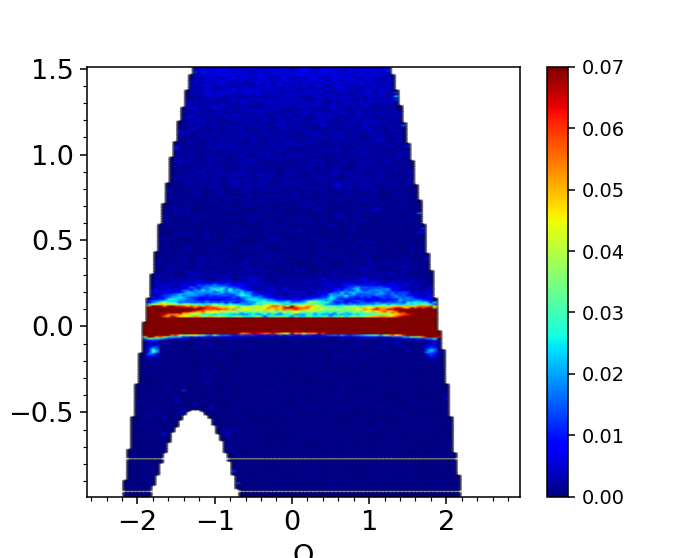

[ 0.95698168  0.95692865  0.95676958  0.95650448  0.95613344  0.95565653
  0.95507385  0.95438555  0.95359176  0.95269269  0.95168852  0.9505795
  0.94936587  0.94804794  0.94662599  0.94510038  0.94347146  0.94173964
  0.93990533  0.93796899  0.9359311   0.93379217  0.93155275  0.92921342
  0.92677477  0.92423747  0.92160217  0.9188696   0.91604048  0.91311561
  0.9100958   0.90698189  0.90377477  0.90047537  0.89708464  0.89360358
  0.89003323  0.88637464  0.88262893  0.87879725  0.87488076  0.8708807
  0.86679831  0.86263488  0.85839173  0.85407023  0.84967178  0.84519779
  0.84064973  0.8360291   0.83133742  0.82657625  0.82174716  0.81685178
  0.81189175  0.80686873  0.80178441  0.79664052  0.79143879  0.78618097]
(60L,) (81L, 54L)


<IPython.core.display.Javascript object>


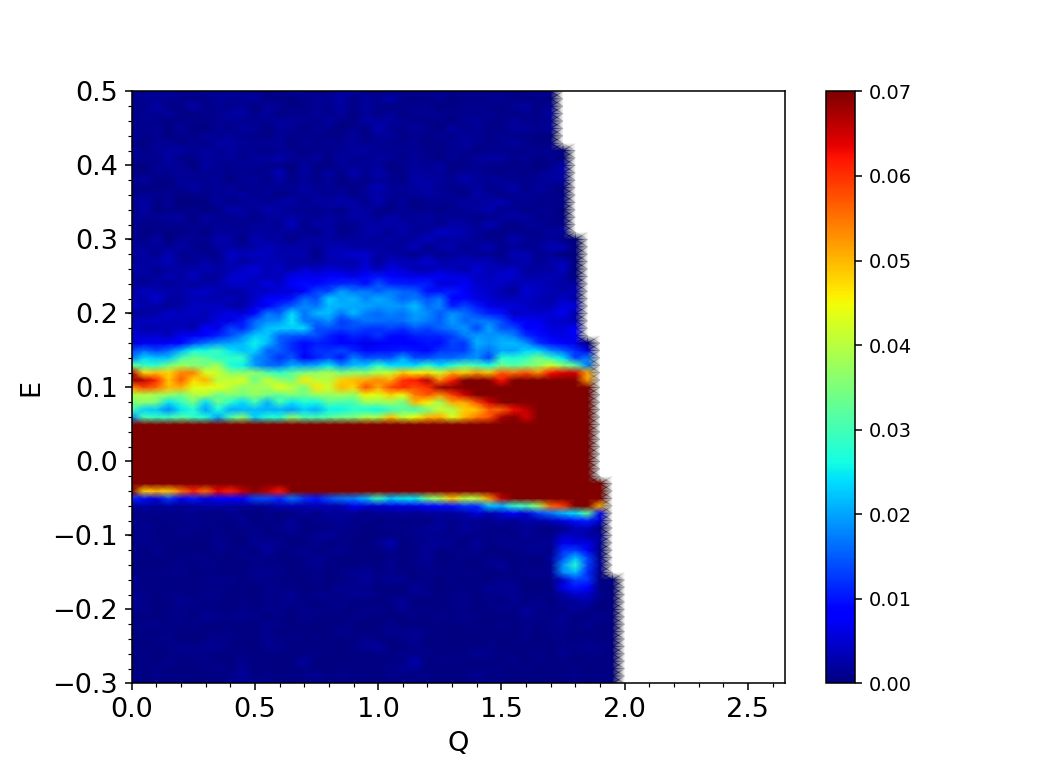

(<matplotlib.figure.Figure at 0x11c77eeb8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11d6e90f0>)

In [215]:
#　Ｎｄ２Ｈｆ２Ｏ７ ５０ｍＫ Ｅ－Ｑ＿ｈｈ２　ｃｕｔ
# Load and plot 
%matplotlib notebook
%matplotlib notebook
X,Y,Z,E = loaddat(r'D:\5_Neutron Scattering\8_IN5_ILL_2017_NdHfO/e-q_hh2.txt')
plotqemap(X,Y,Z,vmin=0,vmax=0.07)

# Crop and fold the 2D data
x0 = np.where(X[0,:]==0)[0]# index of 0: 53
ylim = (Y[:,0]>=-0.3)&(Y[:,0]<=0.5) # energy limit

# [qq2]
qs = np.linspace(0,2.95,num=60,endpoint=True)
es = Y[ylim,0]
# Form factor of hh2
hkl = np.vstack([qs,qs,np.repeat(2.,qs.shape)]).T
qmod = LA.norm( np.multiply(hkl,rA), axis=1)
mff = ndformfact(qmod)
print mff

X = X[ylim,53:107:1]
Y = Y[ylim,53:107:1]
Z = (Z[ylim,53:107:1]+ Z[ylim,53::-1])/2 #fold the data; Z[:,53:107:1] = (Z[:,53:107:1]+ Z[:,53::-1])/2
E = (E[ylim,53:107:1]+ E[ylim,53::-1])/2
Zm = np.ma.masked_where(np.isnan(Z),Z) # mask Nan values then plot in white color
Em = np.ma.masked_where(np.isnan(Z),E)
#Z = np.hstack((np.empty([251,6])*np.nan,Z))
print qs.shape, Zm.shape

plotqemap(X,Y,Zm,vmin=0,vmax=0.07)


In [50]:
a = np.array([1,2,3,4])
print a[4::-1]

hkl = np.vstack([qs,qs,np.repeat(2.,qs.shape)]).T
print np.multiply(hkl,rA)
qmod = LA.norm(np.multiply(hkl,rA),axis=1)
print ndformfact(qmod)
print ndformfact( LA.norm(np.multiply([[3.2,0,0],[2.2,2.2,0]],rA),axis=1) )

[4 3 2 1]
[[ 0.          0.          1.18104987]
 [ 0.02952625  0.02952625  1.18104987]
 [ 0.05905249  0.05905249  1.18104987]
 [ 0.08857874  0.08857874  1.18104987]
 [ 0.11810499  0.11810499  1.18104987]
 [ 0.14763123  0.14763123  1.18104987]
 [ 0.17715748  0.17715748  1.18104987]
 [ 0.20668373  0.20668373  1.18104987]
 [ 0.23620997  0.23620997  1.18104987]
 [ 0.26573622  0.26573622  1.18104987]
 [ 0.29526247  0.29526247  1.18104987]
 [ 0.32478871  0.32478871  1.18104987]
 [ 0.35431496  0.35431496  1.18104987]
 [ 0.38384121  0.38384121  1.18104987]
 [ 0.41336745  0.41336745  1.18104987]
 [ 0.4428937   0.4428937   1.18104987]
 [ 0.47241995  0.47241995  1.18104987]
 [ 0.50194619  0.50194619  1.18104987]
 [ 0.53147244  0.53147244  1.18104987]
 [ 0.56099869  0.56099869  1.18104987]
 [ 0.59052493  0.59052493  1.18104987]
 [ 0.62005118  0.62005118  1.18104987]
 [ 0.64957743  0.64957743  1.18104987]
 [ 0.67910368  0.67910368  1.18104987]
 [ 0.70862992  0.70862992  1.18104987]
 [ 0.73815617  

<IPython.core.display.Javascript object>


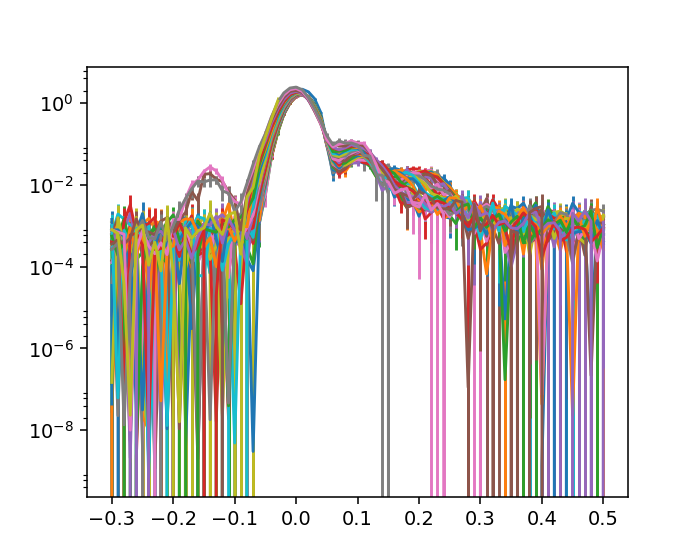

In [109]:
# Plot I-E at every Q
fig = plt.figure(figsize=[5,4])
fig.patch.set_facecolor('white')
from matplotlib import rcParams
rcParams.update({'figure.autolayout': False})
for i in xrange(54):
    #plt.plot(es,Zm[:,i])
    plt.errorbar(es,Zm[:,i],Em[:,i],fmt='-', ms=2,  mfc='white')
plt.yscale('log')
plt.show()

[31 41 52]
[ 0.01  0.11  0.22] [1.755415 0.053340200000000004 0.020706950000000002]
[ 1.75582554  0.00709197  0.01997025  0.05247365  0.10272455  0.02512803
  0.01889347  0.21262487  0.03681069]


<IPython.core.display.Javascript object>


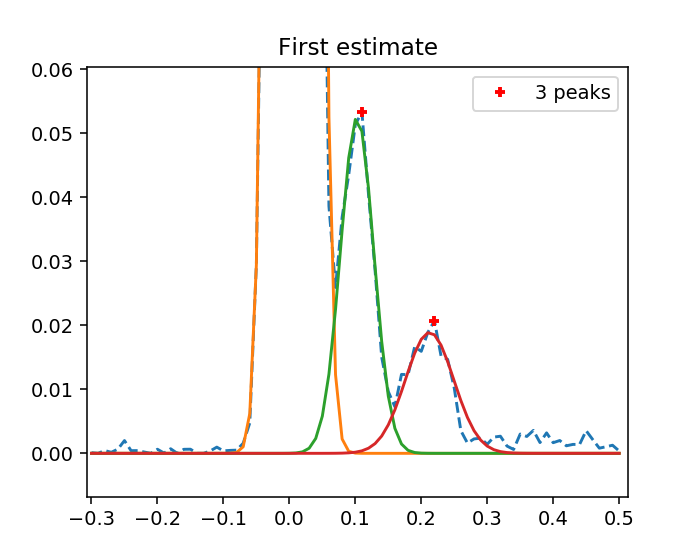

In [89]:
#　Ｔｅｓｔ　ｆｉｎｄ　ｐｅａｋｓ　ａｎｄ　ｆｉｔ　ｗｉｔｈ　Ｂｕｉｌｔ－ｉｎ　ｆｕｎｃｔｉｏｎｓ　（ｆｉｔ　ｐｅａｋｓ　ｓｅｐａｒａｔｌｙ）
wch = 20 # which Q:0-34
indexes = peakutils.indexes(Zm[:,wch], thres=0.01,min_dist=5)
print(indexes)
print es[indexes], Zm[:,wch][indexes]
pk_apw = peakutils.interpolate_xu(es, Zm[:,wch],ind=indexes, width=3)
print(np.asarray(pk_apw).ravel())

plt.figure(figsize=(5,4))
pplot(es, Zm[:,wch], indexes)

fit = peakutils.gaussian(es, ampl=pk_apw[0,0], center=pk_apw[0,1], dev=pk_apw[0,2])
plt.plot(es,fit)
fit = peakutils.gaussian(es, ampl=pk_apw[1,0], center=pk_apw[1,1], dev=pk_apw[1,2])
plt.plot(es,fit)
fit = peakutils.gaussian(es, ampl=pk_apw[2,0], center=pk_apw[2,1], dev=pk_apw[2,2])
plt.plot(es,fit)
plt.title('First estimate')
plt.ylim([-0.02,0.2])
plt.show()

In [ ]:
# Ｆｉｎｄ　ｐｅａｋｓ　ａｎｄ　ｆｉｔ　ｗｉｔｈ　Ｇａｕｓｓｕｏｎ
'''There three peaks for (hh2): elastic, flat and dipersioning. 
The flat mode and the dispersion overlap at some Q and then two peaks are found and fitted'''
datFit = np.zeros([10,11])# set 10 for the binned nb of q, 34 for unbinned
fitpars = []
# for i in xrange(34):
#     x, y = es,Zm[:,i]
for i in xrange(10):# with binning the q
    ii = 3*i+1
    x, y, err = es, (Zm[:,3*i]+Zm[:,3*i+1]+Zm[:,3*i+2])/3, (Em[:,3*i]+Em[:,3*i+1]+Em[:,3*i+2])/3
    indexes = peakutils.indexes(y, thres=0.005,min_dist=5)
    
    #print i, indexes, x[indexes], y[indexes]  
    
    N = len(indexes)
    if N!=0:    
        params_0 = []
        bounds = []
        for j in xrange(N):
            params_0.append([y[indexes[j]]*0.05, x[indexes[j]],(x[1]-x[0])/3.]) # for Gaussion
        params_0 = np.asarray(params_0).ravel()
        
        popt, pcov = curve_fit(lambda x, *params: wrapper_fit_func(x, N, params), x, y, p0=params_0,
                              sigma=err, absolute_sigma=True)
        perr = np.sqrt(np.diag(pcov))
        pars_with_e = np.hstack((qs[ii],popt[3:],perr[3:])).ravel() # without the elastic
        print pars_with_e
        fitpars.append(pars_with_e)
        #print popt, perr
        # store for SpinW fitting
        if N==2:# only 2 or 3 peaks in the data
            datFit[i,0:8] = np.hstack((qs[ii],qs[ii],2,0.05,0.4,popt[3],popt[4],perr[4])).ravel()
        elif N==3:
            datFit[i,0:11] = np.hstack((qs[ii],qs[ii],2,0.05,0.4,popt[3],popt[4],perr[4],
                                       popt[6],popt[7],perr[7])).ravel()

            
    plt.figure(figsize=(3,2))
    #pplot(x, y, indexes)
    plt.errorbar(x, y, err, fmt='o', ms=2,  mfc='white')
    plt.plot(x[indexes], y[indexes], 'r+', ms=5, mew=2,label='{} peaks'.format(len(indexes)))
    
    plt.plot(x,wrapper_fit_func(x,N,popt))
    for i in np.arange(N):
        plt.plot(x,gau_func(x,popt[i*3:(i+1)*3]),lw=0.3)        
    plt.ylim([-0.02,0.2])
    plt.show()
        

<IPython.core.display.Javascript object>


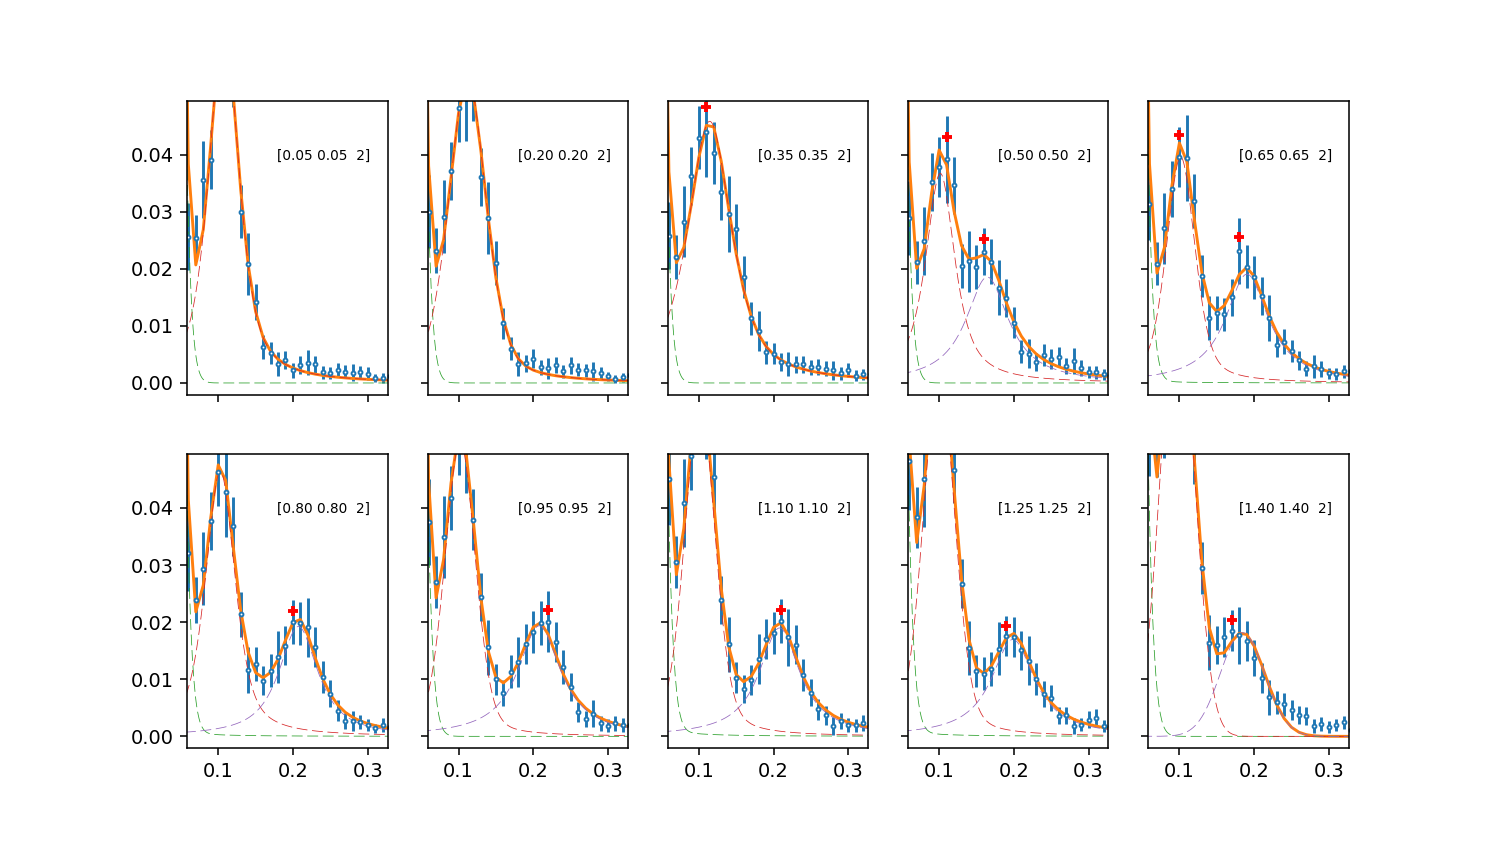

0 [31 41] [ 0.01  0.11] [1.7953333333333334 0.06529498333333335]
Q[HH2] amplitude e posistion e width e fraction e
0.05000
0.084593 0.001307 0.007978 0.000240 0.021173 0.000187 0.000000 0.003860
0.004223 0.000242 0.107695 0.001448 0.023872 0.002635 0.744083 0.143026

1 [31 42] [ 0.01  0.12] [1.6064100000000001 0.051965700000000004]
Q[HH2] amplitude e posistion e width e fraction e
0.20000
0.076789 0.001248 0.007848 0.000252 0.021551 0.000196 0.000000 0.003578
0.004031 0.000249 0.111969 0.001742 0.029693 0.002373 0.492959 0.135151

2 [31 41] [ 0.01  0.11] [1.624795 0.043964583333333335]
Q[HH2] amplitude e posistion e width e fraction e
0.35000
0.077555 0.001294 0.007351 0.000259 0.021323 0.000200 0.000000 0.005237
0.004594 0.000287 0.114594 0.002348 0.035000 0.003854 0.796531 0.147797

3 [31 41 46] [ 0.01  0.11  0.16] [1.666135 0.0391969 0.02296355]
Q[HH2] amplitude e posistion e width e fraction e
0.50000
0.079926 0.001388 0.007425 0.000279 0.021621 0.000211 0.000000 0.008974
0.002545 

In [226]:
# Ｆｉｎｄ　ｐｅａｋｓ　ａｎｄ　ｆｉｔ　ｗｉｔｈ　ＰＶ
'''There three peaks for (hh2): elastic, flat and dipersioning. 
The flat mode and the dispersion overlap at some Q and then two peaks are found and fitted'''

# without I error; set 10 for the binned nb of q, 34 for unbinned
#datFit = np.zeros([10,11]) # storing qx,qy,qz,Emin,Emax,int,e,err,int,e,err
#datFit = np.zeros([10,13])# with I error; set 10 for the binned nb of q, 34 for unbinned
datFit = np.zeros([10,15])  # storing qx,qy,qz,Emin,Emax,Imin,Imax,int,err,e,err,int,err,e,err
fitpars = []

fig, axarr = plt.subplots(2,5, figsize=(10,6),sharex=True,sharey=True)

# for i in xrange(34):
#     x, y = es,Zm[:,i]
eplot=np.linspace(-0.2,0.5,700)
for i in xrange(10):# with binning the q
    ii = 3*i+1
    x, y, err = es, (Zm[:,3*i]+Zm[:,3*i+1]+Zm[:,3*i+2])/3, (Em[:,3*i]+Em[:,3*i+1]+Em[:,3*i+2])/3
    indexes = peakutils.indexes(y, thres=0.008,min_dist=3)# for old data 0.005 5
    
    print i, indexes, x[indexes], y[indexes]  
    
    N = len(indexes)
    if N!=0:    
        params_0, lowBound, highBound = [], [], []
        lb = [0,    -0.2, 0.02,0] # amplitude, pos, withd, frac
        hb = [np.inf,0.32,0.035,1]
        for j in xrange(N):
            params_0.append([y[indexes[j]]*0.05, x[indexes[j]], 0.03, 0.1]) # for PV
            lowBound += lb # lowBound.extend(lb) is better
            highBound += hb
            
        params_0 = np.asarray(params_0).ravel()
        bounds = [lowBound,highBound]
        #print np.all((params_0 >= lowBound) & (params_0 <= highBound))
        #print params_0, '\n', bounds
        popt, pcov = curve_fit(lambda x, *params: wrapper_fit_func_PV(x, N, params), x, y, p0=params_0,
                               bounds=bounds, sigma=err, absolute_sigma=True)# if initio value is outside bounds, error
        perr = np.sqrt(np.diag(pcov))
        
        #print np.vstack((popt[0:],perr[0:]))#.ravel()

        #print popt, perr
        pars_with_e = np.hstack( [qs[ii], np.vstack([popt[0:],perr[0:]]).T.ravel()] ).ravel() # without the elastic
        #print pars_with_e
        print  "Q[HH2] amplitude e posistion e width e fraction e"
        row_format ="{:1.5f}\n"+"{:1.6f} {:1.6f} {:1.6f} {:1.6f} {:1.6f} {:1.6f} {:1.6f} {:1.6f}\n" * (len(pars_with_e)/8)
        print row_format.format(*pars_with_e)

        #fitpars.append(pars_with_e)
        
        # store for SpinW fitting
        
        
        if N==2:# only 2 or 3 peaks in the data
            #datFit[i,0:8] = np.hstack((qs[i],qs[i],2,0.05,0.4,popt[4],popt[5],perr[5])).ravel()
            #datFit[i,0:9] = np.hstack((qs[ii],qs[ii],2,0.05,0.4,popt[4]/popt[4],perr[4]/popt[4],popt[5],perr[5])).ravel()# with I error
            minI, maxI = popt[4]*0.5, popt[4]*1.5
            datFit[i,0:11] = np.hstack((qs[ii],qs[ii],2, 0.05,0.3, minI/mff[ii], maxI/mff[ii],
                                        popt[4]/mff[ii],perr[4]/mff[ii], popt[5],perr[5])).ravel()# with I error
            
        elif N==3:
            #datFit[i,0:11] = np.hstack((qs[i],qs[i],2,0.05,0.4,popt[4],popt[5],perr[5],
                                       #popt[8],popt[9],perr[9])).ravel()
            #datFit[i,0:13] = np.hstack((qs[ii],qs[ii],2,0.05,0.4,popt[4]/popt[4],perr[4]/popt[4],popt[5],perr[5],
                                       #popt[8]/popt[4],perr[8]/popt[4],popt[9],perr[9])).ravel()# with I error
            minI, maxI = np.minimum(popt[4],popt[8]), np.maximum(popt[4],popt[8])
            datFit[i,0:15] = np.hstack((qs[ii],qs[ii],2, 0.05,0.3, minI/mff[ii], maxI/mff[ii], 
                                        popt[4]/mff[ii],perr[4]/mff[ii], popt[5],perr[5],
                                        popt[8]/mff[ii],perr[8]/mff[ii], popt[9],perr[9])).ravel()# with I error

            
#     plt.figure(figsize=(3,2))
#     #pplot(x, y, indexes)
#     plt.errorbar(x, y, err, fmt='o', ms=2,  mfc='white')
#     plt.plot(x[indexes], y[indexes]*1.1, 'r+', ms=5, mew=2,label='{} peaks'.format(len(indexes)))
    
#     plt.plot(x,wrapper_fit_func_PV(x,N,popt))
#     for i in np.arange(N):
#         #print popt[i*4:(i+1)*4]
#         plt.plot(eplot,pvoigt(eplot,*popt[i*4:(i+1)*4]),'--',lw=0.4)
#     plt.xlim([-0.15,0.4])
#     plt.ylim([-0.01,0.09])
#     plt.show()
    
    ax = axarr[i/5,np.remainder(i,5)]    
    ax.errorbar(x, y, err, fmt='o', ms=2,  mfc='white')
    ax.plot(x[indexes], y[indexes]*1.1, 'r+', ms=5, mew=2,label='{} peaks'.format(len(indexes)))
    
    ax.plot(x,wrapper_fit_func_PV(x,N,popt))
    for j in np.arange(N):
        ax.plot(eplot, pvoigt(eplot,*popt[j*4:(j+1)*4]),'--',lw=0.4)
    ax.set_xlim([-0.15,0.4])
    ax.set_ylim([-0.01,0.09])
    ax.text(0.45,0.8, '[' + '{:1.2f} '.format(qs[ii])*2 + r' 2]',fontsize=7, transform=ax.transAxes)
    
plt.suptitle(r'Nd$_2$Zr$_2$O$__7$ [HH2]')
plt.show()    
    
#print fitpars  

In [58]:
#print np.vstack(fitpars)
#from __future__ import print_function
# f = r'D:\5_Neutron Scattering\8_IN5_ILL_2017_NdHfO\test.txt'
# for item in fitpars:
#     print(str(item.tolist()), file=f)
    
# with open(r'D:\5_Neutron Scattering\8_IN5_ILL_2017_NdHfO\test.txt', 'w+') as f:
#     for item in fitpars:
#         #f.write("%s\n" % item.tolist()) # add tolist otherwise np array has \n
#         #f.write(*item.tolist()) # add tolist otherwise np array has \n
#         print(item.tolist(), file=f)

In [139]:
# Test normalization
print datFit[:,[7,11]]
Imax = datFit[:,[7,11]].max()
datFit[:,[5,6,7,8,11,12]] = datFit[:,[5,6,7,8,11,12]]/Imax
print datFit[:,[5,6,7,8,11,12]]

[[ 0.00435993  0.        ]
 [ 0.00446095  0.        ]
 [ 0.00470546  0.        ]
 [ 0.00303127  0.00160323]
 [ 0.00280789  0.0018068 ]
 [ 0.00301789  0.00185631]
 [ 0.00334829  0.00188413]
 [ 0.00366084  0.00181908]
 [ 0.00434599  0.00157915]
 [ 0.00418473  0.00199408]]
[[ 0.4632837   1.38985111  0.92656741  0.03046047  0.          0.        ]
 [ 0.47401752  1.42205257  0.94803504  0.03218536  0.          0.        ]
 [ 0.5         1.5         1.          0.03556766  0.          0.        ]
 [ 0.64420199  0.64420199  0.64420199  0.16482526  0.3407158   0.10321129]
 [ 0.59672953  0.59672953  0.59672953  0.09298377  0.38397945  0.05437686]
 [ 0.64135932  0.64135932  0.64135932  0.07449685  0.39450014  0.04118373]
 [ 0.71157521  0.71157521  0.71157521  0.06758748  0.40041301  0.03760306]
 [ 0.77799849  0.77799849  0.77799849  0.07325812  0.38658828  0.04014594]
 [ 0.92360443  0.92360443  0.92360443  0.08947019  0.33559978  0.04702924]
 [ 0.8893334   0.8893334   0.8893334   0.12453337  0.4

<IPython.core.display.Javascript object>


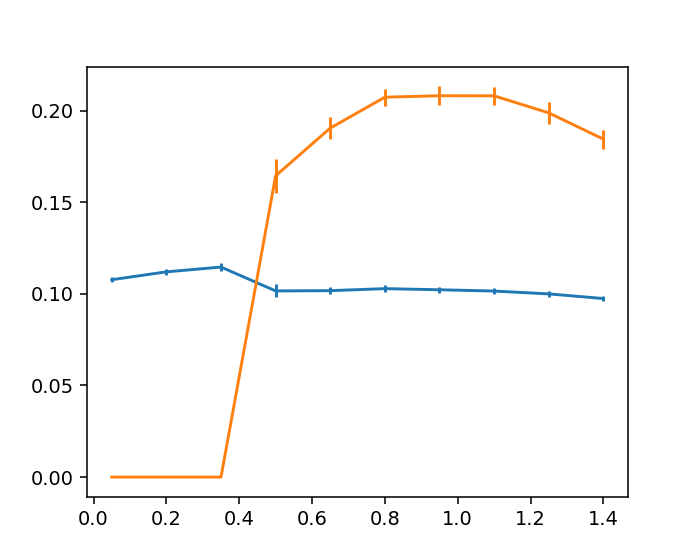

In [111]:
# Plot and save the fitted dispersion for SpinW fitting

# data without I error for the original Spinw format
# plt.figure(figsize=(5,4))
# plt.errorbar(datFit[:,0],datFit[:,6],datFit[:,7])
# plt.errorbar(datFit[:,0],datFit[:,9],datFit[:,10])
# plt.show()
#print np.asanyarray(fitpars)
#print datFit

# data with I error
# plt.figure(figsize=(5,4))
# plt.errorbar(datFit[:,0],datFit[:,7],datFit[:,8])
# plt.errorbar(datFit[:,0],datFit[:,11],datFit[:,12])
# plt.show()

# data with I error, minI and maxI
plt.figure(figsize=(5,4))
plt.errorbar(datFit[:,0],datFit[:,9],datFit[:,10])
plt.errorbar(datFit[:,0],datFit[:,13],datFit[:,14])
plt.show()

fname = 'fitted_spinw_hh2_qie.txt'
# original Spinw format
header = ['QH','QK','QL','ENlim1','ENlim2','I1','EN1','sigma1','I2','EN2','sigma2']
# data with I error
header = ['QH','QK','QL','ENlim1','ENlim2','I1','sigmaI1','EN1','sigma1','I2','sigmaI2','EN2','sigma2']
# data with I error, minI and maxI
# indexes  0    1     2      3        4       5        6       7      8       9       10    11     12       13     14 
header = ['QH','QK','QL','ENlim1','ENlim2','INlim1','INlim2','I1','sigmaI1','EN1','sigma1','I2','sigmaI2','EN2','sigma2']
Imax = datFit[:,[7,11]].max()
#datFit[:,[5,6,7,8,11,12]] = datFit[:,[5,6,7,8,11,12]]/Imax # normalize the intensity
#np.savetxt(os.path.join(fpath,fname),datFit, fmt="%.5f", header=' '.join(header)) # workings


0 [31 41] [ 0.01  0.11] [1.7251283333333334 0.06361670000000001]
[ 1.72512833  0.01        0.01        1.72512833  0.11        0.01
  1.72512833  0.16        0.01      ]
[ 0.05857281  0.00860826  0.0189554   0.00200369  0.10605241  0.01811528
  0.00033776  0.14705798  0.01      ]
[ 0.05        0.00200369  0.10605241  0.01811528  0.00033776  0.14705798
  0.01               inf         inf         inf         inf         inf]


<IPython.core.display.Javascript object>


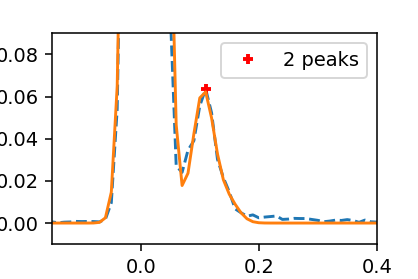

1 [31 41] [ 0.01  0.11] [1.6113483333333332 0.05266571666666667]
[ 1.61134833  0.01        0.01        1.61134833  0.11        0.01
  1.61134833  0.16        0.01      ]
[ 0.05513824  0.00835139  0.01922773  0.00160175  0.10409745  0.0177269
  0.00070714  0.13909271  0.01      ]
[ 0.2         0.00160175  0.10409745  0.0177269   0.00070714  0.13909271
  0.01               inf         inf         inf         inf         inf]


<IPython.core.display.Javascript object>


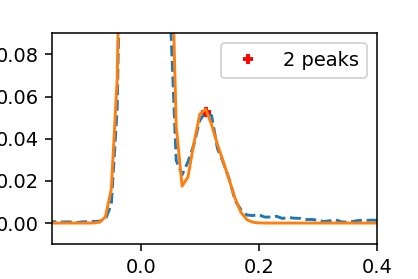

2 [31 41] [ 0.01  0.11] [1.622915 0.0437905]
[ 1.622915  0.01      0.01      1.622915  0.11      0.01      1.622915
  0.16      0.01    ]
[ 0.05612058  0.00790443  0.01928844  0.00147353  0.10345925  0.01827475
  0.00083094  0.1469373   0.01      ]
[ 0.35        0.00147353  0.10345925  0.01827475  0.00083094  0.1469373
  0.01               inf         inf         inf         inf         inf]


<IPython.core.display.Javascript object>


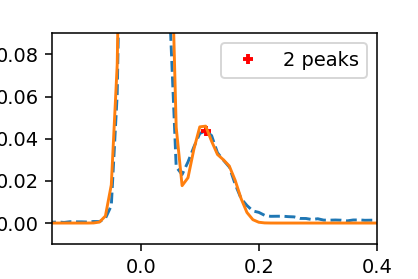

3 [31 40 46] [ 0.01  0.1   0.16] [1.662888333333333 0.038873733333333334 0.02204465]
[ 0.05718515  0.00788262  0.01929418  0.00111556  0.10049439  0.0164028
  0.00129507  0.16013425  0.034266  ]
[ 0.5         0.00111556  0.10049439  0.0164028   0.00129507  0.16013425
  0.034266    0.00455179  0.00482068  0.00063374  0.01921794  0.0171688 ]


<IPython.core.display.Javascript object>


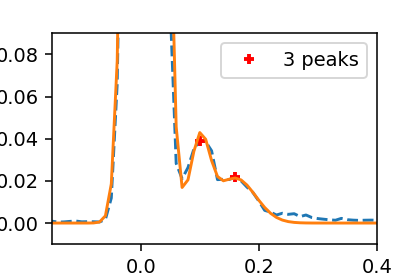

4 [31 40 48] [ 0.01  0.1   0.18] [1.688583333333333 0.04024716666666667 0.021993616666666663]
[ 0.0579355   0.00786056  0.01934025  0.00130445  0.10260078  0.01726117
  0.00125382  0.18662784  0.03673025]
[  6.50000000e-01   1.30444913e-03   1.02600778e-01   1.72611705e-02
   1.25381634e-03   1.86627835e-01   3.67302518e-02   3.36430689e-03
   3.39122414e-03   3.52291461e-04   1.14165093e-02   1.26644863e-02]


<IPython.core.display.Javascript object>


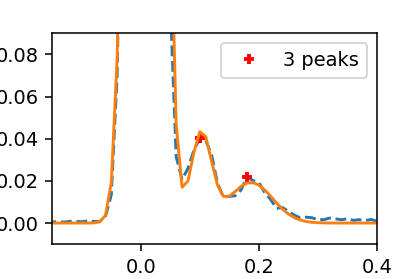

5 [31 40 50] [ 0.01  0.1   0.2 ] [1.7153650000000003 0.04466336666666667 0.0199714]
[ 0.05982331  0.00762489  0.01946786  0.00156229  0.10401986  0.01836617
  0.00126707  0.20250868  0.03729754]
[  8.00000000e-01   1.56228916e-03   1.04019864e-01   1.83661728e-02
   1.26706775e-03   2.02508679e-01   3.72975406e-02   2.73464245e-03
   2.77943413e-03   2.95030696e-04   9.66581818e-03   1.06634063e-02]


<IPython.core.display.Javascript object>


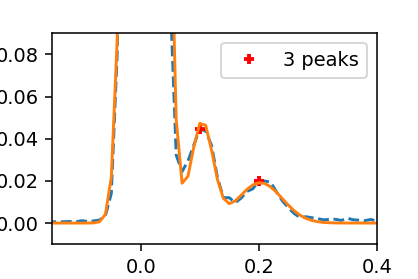

6 [31 40 51] [ 0.01  0.1   0.21] [1.7581583333333335 0.05333849999999999 0.019911916666666665]
[ 0.06165824  0.00711873  0.01954869  0.00184699  0.10308597  0.01887513
  0.00124019  0.2070995   0.0372916 ]
[  9.50000000e-01   1.84699388e-03   1.03085971e-01   1.88751265e-02
   1.24018814e-03   2.07099499e-01   3.72916029e-02   1.95835462e-03
   1.99992678e-03   2.37121766e-04   7.97800647e-03   8.69256755e-03]


<IPython.core.display.Javascript object>


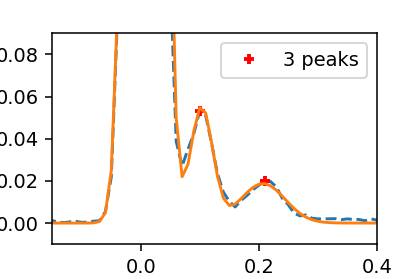

7 [31 41 51] [ 0.01  0.11  0.21] [1.753685 0.05845691666666667 0.019483066666666663]
[ 0.06208869  0.00680317  0.01976289  0.00214101  0.10305865  0.01941623
  0.00117128  0.20551661  0.03617988]
[  1.10000000e+00   2.14101308e-03   1.03058653e-01   1.94162319e-02
   1.17127636e-03   2.05516608e-01   3.61798751e-02   1.72791390e-03
   1.77046695e-03   2.28844468e-04   7.90074680e-03   8.62613360e-03]


<IPython.core.display.Javascript object>


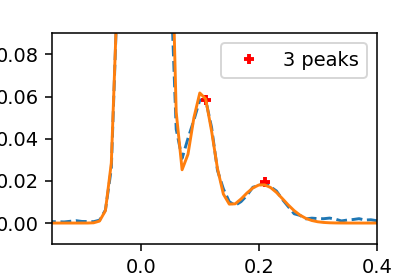

8 [31 40 50] [ 0.01  0.1   0.2 ] [1.7594116666666666 0.0659686 0.01728616666666667]
[ 0.06392831  0.00572934  0.02006707  0.00232723  0.10070942  0.01936993
  0.00117638  0.19513619  0.04020634]
[  1.25000000e+00   2.32723489e-03   1.00709422e-01   1.93699310e-02
   1.17637802e-03   1.95136190e-01   4.02063423e-02   1.42487397e-03
   1.44484457e-03   2.30611362e-04   8.71780014e-03   9.68817458e-03]


<IPython.core.display.Javascript object>


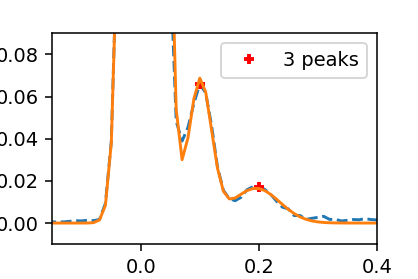

9 [31 40 47] [ 0.01  0.1   0.17] [1.7691616666666665 0.07383094999999999 0.018147800000000002]
[ 0.06555737  0.0048792   0.02022469  0.00264339  0.09743209  0.01946445
  0.00128946  0.17179284  0.04213091]
[  1.40000000e+00   2.64339265e-03   9.74320892e-02   1.94644487e-02
   1.28945503e-03   1.71792838e-01   4.21309144e-02   1.54942065e-03
   1.67976941e-03   4.22002011e-04   1.57425092e-02   1.46220096e-02]


<IPython.core.display.Javascript object>


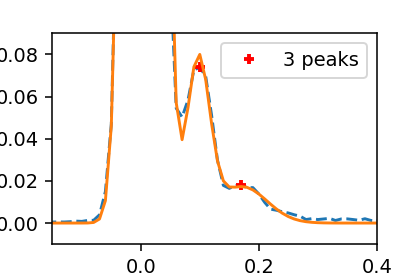

In [126]:
# Ｆｉｎｄ　ｐｅａｋｓ　ａｎｄ　ｆｉｔ　ｗｉｔｈ　Ｇａｕｓｓｕｏｎ： force to have 3 peaks (the two inelastic peaks constrained same width)
fitpars = []
datFit = np.zeros([10,11])# set 10 for the binned nb of q, 34 for unbinned

# for i in xrange(34):
#     x, y = es,Zm[:,i]
for i in xrange(10):# with binning the q
    ii = 3*i+1
    x, y = es, (Zm[:,3*i]+Zm[:,3*i+1]+Zm[:,3*i+2])/3
    indexes = peakutils.indexes(y, thres=0.005,min_dist=5)
    print i, indexes, x[indexes], y[indexes]  
    
    N = len(indexes)
    params_0 = []
    if N==3:     
        for j in xrange(N):
            params_0.append([np.max(y), x[indexes[j]],(x[1]-x[0])])
        params_0 = np.asarray(params_0).ravel()
        
    elif N==2:# if 2 pk found, add another params for a third peak with the same peak width as the second peak
        for j in xrange(N):
            params_0.append([np.max(y), x[indexes[j]],(x[1]-x[0])])
        params_0 = np.append(params_0,[np.max(y), x[indexes[N-1]]+0.05,(x[1]-x[0])])
        params_0 = np.asarray(params_0).ravel()  
        print params_0
    # 'wrapper_fit_func1' has constrained the same peak width for the 2nd and 3rd peak
    popt, pcov = curve_fit(lambda x, *params: wrapper_fit_func1(x, N, params), x, y, p0=params_0)
    perr = np.sqrt(np.diag(pcov))
    print popt
    pars_with_e = np.hstack((qs[ii],popt[3:],perr[4:])).ravel() # without the elastic
    print pars_with_e
    fitpars.append(pars_with_e)
    datFit[i,0:11] = np.hstack((qs[ii],qs[ii],2,0.05,0.4,popt[3],popt[4],perr[4],
                                       popt[6],popt[7],perr[7])).ravel()
    # plot       
    plt.figure(figsize=(3,2))
    pplot(x, y, indexes)
    plt.plot(x,wrapper_fit_func1(x,N,popt))
    plt.xlim([-0.15,0.4])
    plt.ylim([-0.01,0.09])
    plt.show()
        

<IPython.core.display.Javascript object>


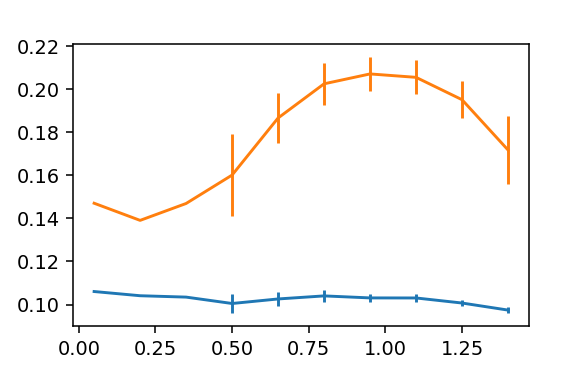

In [127]:
# Plot and save the fitted dispersion
plt.figure(figsize=(5,4))
plt.errorbar(datFit[:,0],datFit[:,6],datFit[:,7])
plt.errorbar(datFit[:,0],datFit[:,9],datFit[:,10])
plt.show()
#print np.asanyarray(fitpars)
#print datFit

fname = 'fitted_spinw_hh2_qie.txt'
header = ['QH','QK','QL','ENlim1','ENlim2','I1','EN1','sigma1','I2','EN2','sigma2']

#np.savetxt(os.path.join(fpath,fname),datFit, fmt="%.3f", header=' '.join(header)) # workings

2 [ 0.08625642  0.01        0.02        0.1         0.00318084  0.11        0.02
  0.1         0.00159042  0.13      ] 
[[0, -0.2, 0.02, 0, 0, -0.2, 0.02, 0, 0, -0.2], [inf, 0.5, 0.03, 1, inf, 0.5, 0.03, 1, inf, 0.5]]
Q[HH2] amplitude e posistion e width e fraction e
0.00000
0.081759 0.000830 0.008199 0.000179 0.021240 0.000146 0.002334 0.003907
0.004528 0.000217 0.107468 0.001063 0.023285 0.002288 0.968270 0.126681
0.000086 0.000035 0.275892 0.011901


<IPython.core.display.Javascript object>


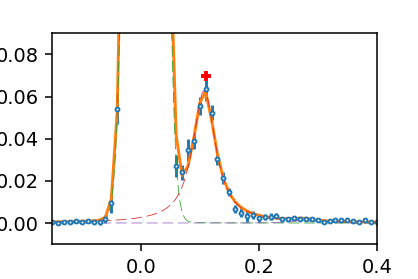

2 [ 0.08056742  0.01        0.02        0.1         0.00263329  0.11        0.02
  0.1         0.00131664  0.13      ] 
[[0, -0.2, 0.02, 0, 0, -0.2, 0.02, 0, 0, -0.2], [inf, 0.5, 0.03, 1, inf, 0.5, 0.03, 1, inf, 0.5]]
Q[HH2] amplitude e posistion e width e fraction e
0.05086
0.076610 0.000835 0.007989 0.000191 0.021510 0.000156 0.000000 0.005212
0.004509 0.003299 0.110853 0.010952 0.028364 0.007782 0.859936 0.235530
0.000066 0.003297 0.134409 0.446755


<IPython.core.display.Javascript object>


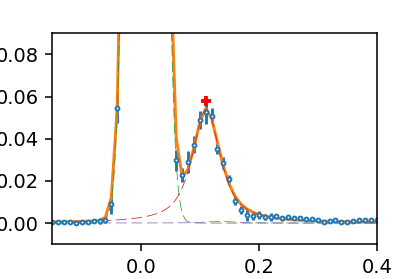

2 [ 0.08114575  0.01        0.02        0.1         0.00218953  0.11        0.02
  0.1         0.00109476  0.13      ] 
[[0, -0.2, 0.02, 0, 0, -0.2, 0.02, 0, 0, -0.2], [inf, 0.5, 0.03, 1, inf, 0.5, 0.03, 1, inf, 0.5]]
Q[HH2] amplitude e posistion e width e fraction e
0.10172
0.077984 0.000835 0.007534 0.000187 0.021426 0.000155 0.006844 0.005131
0.003866 0.000672 0.105147 0.004222 0.030000 0.005981 1.000000 0.206246
0.001246 0.000653 0.140654 0.009554


<IPython.core.display.Javascript object>


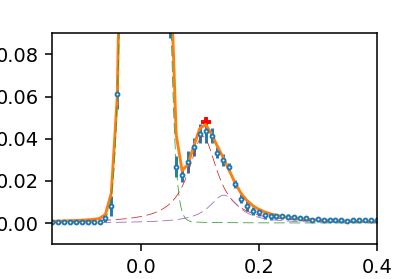

3 [ 0.08314442  0.01        0.02        0.1         0.00194369  0.1         0.02
  0.1         0.00110223  0.16        0.02        0.1       ] 
[[0, -0.2, 0.02, 0, 0, -0.2, 0.02, 0, 0, -0.2, 0.02, 0], [inf, 0.5, 0.03, 1, inf, 0.5, 0.03, 1, inf, 0.5, 0.03, 1]]
Q[HH2] amplitude e posistion e width e fraction e
0.15259
0.079817 0.000870 0.007491 0.000185 0.021554 0.000153 0.011681 0.008460
0.003587 0.000681 0.102616 0.002475 0.030000 0.004795 1.000000 0.252662
0.001406 0.000413 0.171072 0.004205 0.030000 0.007034 1.000000 0.274781



<IPython.core.display.Javascript object>


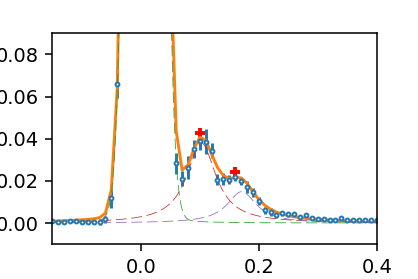

3 [ 0.08442917  0.01        0.02        0.1         0.00201236  0.1         0.02
  0.1         0.00109968  0.18        0.02        0.1       ] 
[[0, -0.2, 0.02, 0, 0, -0.2, 0.02, 0, 0, -0.2, 0.02, 0], [inf, 0.5, 0.03, 1, inf, 0.5, 0.03, 1, inf, 0.5, 0.03, 1]]
Q[HH2] amplitude e posistion e width e fraction e
0.20345
0.080853 0.000865 0.007471 0.000182 0.021724 0.000150 0.006607 0.007934
0.003407 0.000535 0.101057 0.002355 0.030000 0.004413 1.000000 0.252593
0.001571 0.000279 0.193361 0.003041 0.030000 0.004837 1.000000 0.187530



<IPython.core.display.Javascript object>


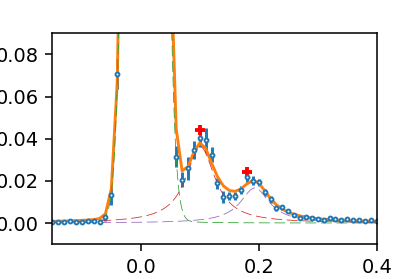

3 [ 0.08576825  0.01        0.02        0.1         0.00223317  0.1         0.02
  0.1         0.00099857  0.2         0.02        0.1       ] 
[[0, -0.2, 0.02, 0, 0, -0.2, 0.02, 0, 0, -0.2, 0.02, 0], [inf, 0.5, 0.03, 1, inf, 0.5, 0.03, 1, inf, 0.5, 0.03, 1]]
Q[HH2] amplitude e posistion e width e fraction e
0.25431
0.083779 0.000840 0.007237 0.000174 0.021998 0.000143 0.004240 0.004851
0.002911 0.000360 0.103581 0.001431 0.023496 0.002312 0.651595 0.289511
0.001897 0.000181 0.207929 0.002140 0.030000 0.003495 1.000000 0.135754



<IPython.core.display.Javascript object>


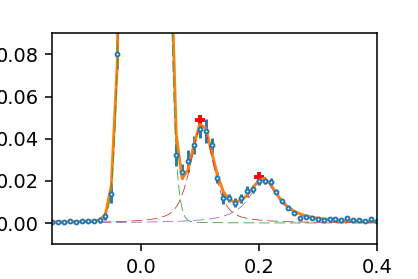

3 [ 0.08790792  0.01        0.02        0.1         0.00266692  0.1         0.02
  0.1         0.0009956   0.21        0.02        0.1       ] 
[[0, -0.2, 0.02, 0, 0, -0.2, 0.02, 0, 0, -0.2, 0.02, 0], [inf, 0.5, 0.03, 1, inf, 0.5, 0.03, 1, inf, 0.5, 0.03, 1]]
Q[HH2] amplitude e posistion e width e fraction e
0.30517
0.086137 0.000851 0.006686 0.000169 0.022121 0.000140 0.004658 0.006103
0.004499 0.000385 0.099851 0.001767 0.030000 0.003274 1.000000 0.167610
0.001458 0.000160 0.215129 0.001895 0.026957 0.003323 0.933990 0.166876



<IPython.core.display.Javascript object>


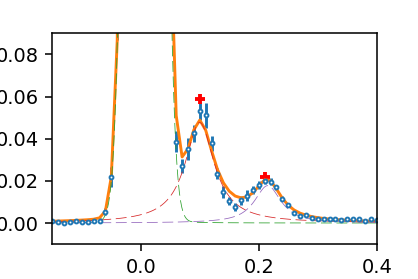

3 [ 0.08768425  0.01        0.02        0.1         0.00292285  0.11        0.02
  0.1         0.00097415  0.21        0.02        0.1       ] 
[[0, -0.2, 0.02, 0, 0, -0.2, 0.02, 0, 0, -0.2, 0.02, 0], [inf, 0.5, 0.03, 1, inf, 0.5, 0.03, 1, inf, 0.5, 0.03, 1]]
Q[HH2] amplitude e posistion e width e fraction e
0.35603
0.087115 0.000839 0.006407 0.000166 0.022513 0.000136 0.009846 0.004392
0.004230 0.000337 0.101775 0.001200 0.023673 0.002120 0.888521 0.178094
0.001590 0.000162 0.211377 0.002287 0.030000 0.003776 0.949140 0.156365



<IPython.core.display.Javascript object>


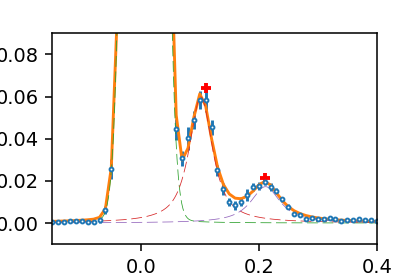

3 [ 0.08797058  0.01        0.02        0.1         0.00329843  0.1         0.02
  0.1         0.00086431  0.2         0.02        0.1       ] 
[[0, -0.2, 0.02, 0, 0, -0.2, 0.02, 0, 0, -0.2, 0.02, 0], [inf, 0.5, 0.03, 1, inf, 0.5, 0.03, 1, inf, 0.5, 0.03, 1]]
Q[HH2] amplitude e posistion e width e fraction e
0.40690
0.089779 0.000846 0.005246 0.000160 0.023109 0.000131 0.002304 0.004767
0.004326 0.000397 0.100047 0.001044 0.024453 0.001534 0.620158 0.208364
0.001586 0.000203 0.202465 0.002758 0.030000 0.004387 1.000000 0.170558



<IPython.core.display.Javascript object>


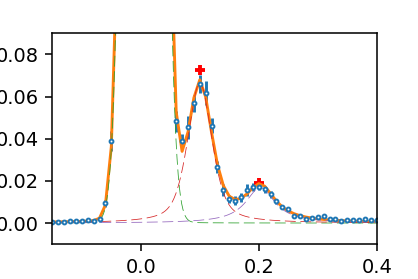

3 [ 0.08845808  0.01        0.02        0.1         0.00369155  0.1         0.02
  0.1         0.00090739  0.17        0.02        0.1       ] 
[[0, -0.2, 0.02, 0, 0, -0.2, 0.02, 0, 0, -0.2, 0.02, 0], [inf, 0.5, 0.03, 1, inf, 0.5, 0.03, 1, inf, 0.5, 0.03, 1]]
Q[HH2] amplitude e posistion e width e fraction e
0.45776
0.092226 0.000869 0.004348 0.000159 0.023509 0.000130 0.002463 0.006049
0.004185 0.000586 0.097369 0.000892 0.026050 0.001100 0.016735 0.346853
0.001994 0.000321 0.180150 0.002731 0.030000 0.004776 1.000000 0.168213



<IPython.core.display.Javascript object>


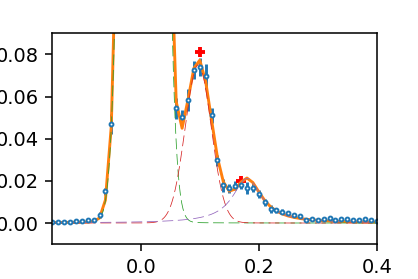

In [77]:
# Ｆｉｎｄ　ｐｅａｋｓ　ａｎｄ　ｆｉｔ　ｗｉｔｈ　ＰＶ： force to have 3 peaks (the two inelastic peaks constrained same width)
fitpars = []
datFit = np.zeros([10,11])# set 10 for the binned nb of q, 34 for unbinned

eplot=np.linspace(-0.2,0.5,700)

for i in xrange(10):# with binning the q
    x, y, err = es, (Zm[:,3*i]+Zm[:,3*i+1]+Zm[:,3*i+2])/3, (Em[:,3*i]+Em[:,3*i+1]+Em[:,3*i+2])/3
    indexes = peakutils.indexes(y, thres=0.005,min_dist=5)
    #print i, indexes, x[indexes], y[indexes]  
    
    N = len(indexes)
    params_0, lowBound, highBound = [], [], []
    lb = [0,    -0.2,0.02,0]
    hb = [np.inf,0.5,0.03,1]
    
    if N==3:     
        for j in xrange(N):
            params_0 += [y[indexes[j]]*0.05, x[indexes[j]], 0.02, 0.1] # for PV
            lowBound += lb
            highBound += hb 
        row_format ="{:1.5f}\n"+"{:1.6f} {:1.6f} {:1.6f} {:1.6f} {:1.6f} {:1.6f} {:1.6f} {:1.6f}\n" * N
                
    elif N==2:# if 2 pk found, add another params for a third peak with the same peak width as the second peak
        for j in xrange(N):
            params_0 += [y[indexes[j]]*0.05, x[indexes[j]], 0.02, 0.1] # for PV
            lowBound += lb
            highBound += hb
        # add two new pars area and pos and their bounds
        params_0 += [y[indexes[1]]*0.025, x[indexes[1]]+0.02] 
        lowBound += [0, -0.2]
        highBound += [np.inf,0.5]
        
        row_format ="{:1.5f}\n"+"{:1.6f} {:1.6f} {:1.6f} {:1.6f} {:1.6f} {:1.6f} {:1.6f} {:1.6f}\n" * N \
                    +"{:1.6f} {:1.6f} {:1.6f} {:1.6f}"
          
    params_0 = np.asarray(params_0).ravel()  
    bounds = [lowBound,highBound]
        
    print N, params_0, '\n', bounds
        
    # 'wrapper_fit_func1_PV' has constrained the same peak width for the 2nd and 3rd peak
    popt, pcov = curve_fit(lambda x, *params: wrapper_fit_func1_PV(x, N, params), x, y, p0=params_0,
                           bounds=bounds, sigma=err, absolute_sigma=True)# if initio value is outside bounds, error
    perr = np.sqrt(np.diag(pcov))

    pars_with_e = np.hstack( [qs[i], np.vstack([popt[0:],perr[0:]]).T.ravel()] ).ravel() # without the elastic
    #print pars_with_e
    print  "Q[HH2] amplitude e posistion e width e fraction e"
    print row_format.format(*pars_with_e)
    
    # plot       
    plt.figure(figsize=(3,2))
    #pplot(x, y, indexes)
    plt.errorbar(x, y, err, fmt='o', ms=2,  mfc='white')
    plt.plot(x[indexes], y[indexes]*1.1, 'r+', ms=5, mew=2,label='{} peaks'.format(len(indexes)))
    plt.plot(x,wrapper_fit_func1_PV(x,N,popt))
    for i in np.arange(N):
        plt.plot(eplot,pvoigt(eplot,*popt[i*4:(i+1)*4]),'--',lw=0.4)
    if N==2:
        plt.plot(eplot,pvoigt(eplot,popt[8],popt[9],popt[6],popt[7]),'--',lw=0.4)
    plt.xlim([-0.15,0.4])
    plt.ylim([-0.01,0.09])
    plt.show()
 

## Q=hh0 data

D:\5_Neutron Scattering\8_IN5_ILL_2017_NdHfO/e-q_11l.txt


<IPython.core.display.Javascript object>


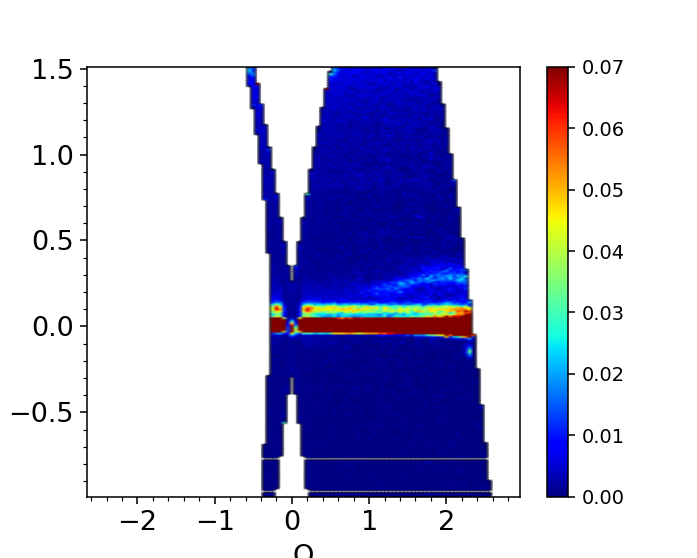

[ 0.99912878  0.99863889  0.99804032  0.99733317  0.99651757  0.99559366
  0.99456162  0.99342163  0.99217392  0.9908187   0.98935625  0.98778685
  0.9861108   0.98432844  0.98244014  0.98044628  0.97834728  0.97614359
  0.97383568  0.97142407  0.96890928  0.9662919   0.96357253  0.96075182
  0.95783043  0.95480908  0.95168852  0.94846954  0.94515296  0.94173964
  0.93823049  0.93462645  0.9309285   0.92713767  0.92325502  0.91928166]


<IPython.core.display.Javascript object>


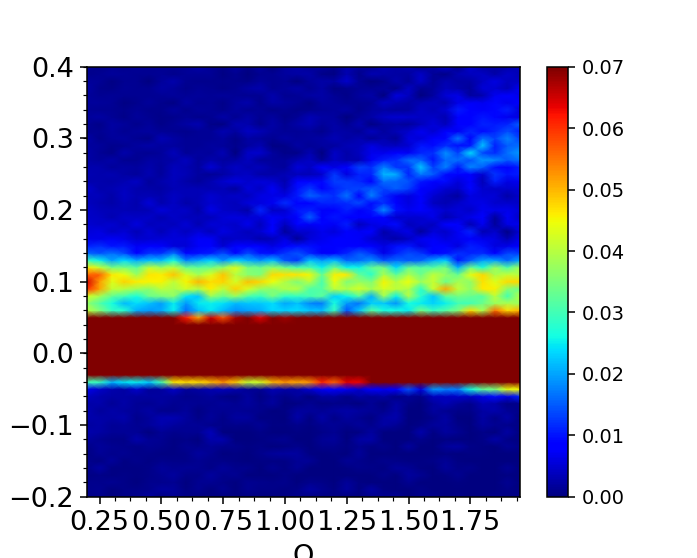

(61L, 36L)


In [228]:
# Load and plot 
X,Y,Z,E = loaddat(r'D:\5_Neutron Scattering\8_IN5_ILL_2017_NdHfO/e-q_hh0.txt')
print fnames[0]
plotqemap(X,Y,Z,vmin=0,vmax=0.07)

# Crop the 2D data and plot
# use 'where' to select: if only give the condition, 'where' returns a tuple (array([index]),dtype=)!!!
xlim = np.where( (X[0,:]>=0.2)&(X[0,:]<2) )[0]# Q limit
ylim = np.where( (Y[:,0]>=-0.2)&(Y[:,0]<=0.4) )[0] # energy limit
# or without 'where': output is an bool array
# xlim = (X[0,:]>=0.2)&(X[0,:]<2) # Q limit
# ylim = (Y[:,0]>=-0.2)&(Y[:,0]<=0.4)  # energy limit

# the q and e 1D array [hh0]
qs = X[0,xlim]
es = Y[ylim,0]

# Form factor of hh0
hkl = np.vstack([qs,qs,np.repeat(0.,qs.shape)]).T
qmod = LA.norm( np.multiply(hkl,rA), axis=1)
mff = ndformfact(qmod)
print mff

# the cropped X; X = X[np.ix_(ylim,xlim)] also works using this corss indexing but not X = X[ylim,xlim]
X = X[ylim,:][:,xlim]
Y = Y[ylim,:][:,xlim]
Z = Z[ylim,:][:,xlim]   
E = E[ylim,:][:,xlim] 
Zm = np.ma.masked_where(np.isnan(Z),Z) # mask Nan values then plot in white color
Em = np.ma.masked_where(np.isnan(Z),E)
plotqemap(X,Y,Zm,vmin=0,vmax=0.07)
print Zm.shape

# Plot I-E at every Q
# plt.figure(figsize=[5,4])
# for i in xrange(16,17):
#     plt.plot(es,Zm[:,i])
# #plt.yscale('log')
# plt.show()


12
[ 0.99860266  0.99648147  0.99338572  0.9893206   0.98429313  0.97831239
  0.97138968  0.96353875  0.95477601  0.94512071  0.93459515  0.92322479]
2  peaks found!!! [21 30]
0 21
1 30
0 [21 30] [ 0.01  0.1 ] [ 2.28945333  0.0533513 ]
[ 0.07264274  0.0102205   0.01717595  0.00243463  0.10249218  0.02712369]


<IPython.core.display.Javascript object>


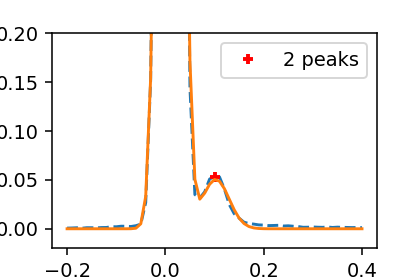

2  peaks found!!! [21 30]
0 21
1 30
1 [21 30] [ 0.01  0.1 ] [ 1.67241333  0.04647323]
[ 0.05350435  0.00941288  0.01719764  0.00194345  0.1041555   0.02536278]


<IPython.core.display.Javascript object>


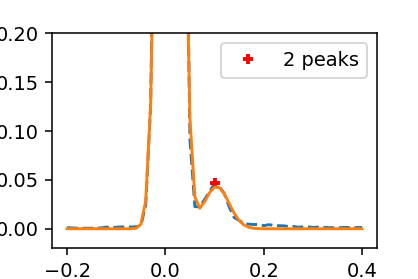

2  peaks found!!! [21 31]
0 21
1 31
2 [21 31] [ 0.01  0.11] [ 1.69854667  0.04599783]
[ 0.05504828  0.00729683  0.0173277   0.00194459  0.10353444  0.02432554]


<IPython.core.display.Javascript object>


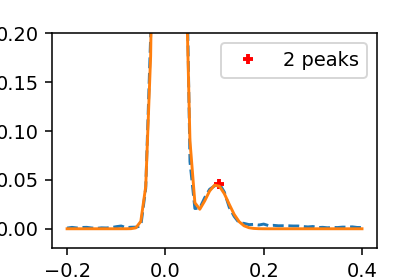

2  peaks found!!! [21 30]
0 21
1 30
3 [21 30] [ 0.01  0.1 ] [ 1.64723667  0.0484671 ]
[ 0.05448936  0.00631615  0.01731541  0.00204094  0.10174565  0.02583498]


<IPython.core.display.Javascript object>


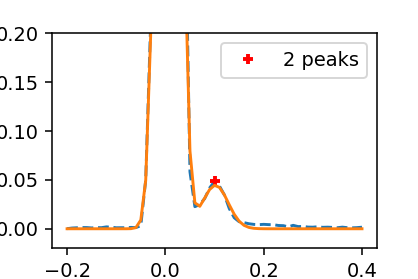

2  peaks found!!! [21 30]
0 21
1 30
4 [21 30] [ 0.01  0.1 ] [ 1.73222333  0.0465549 ]
[ 0.0573927   0.0071097   0.01715941  0.00196108  0.10270605  0.02494571]


<IPython.core.display.Javascript object>


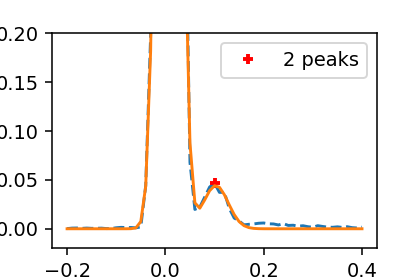

2  peaks found!!! [21 31]
0 21
1 31
5 [21 31] [ 0.01  0.11] [ 1.75770333  0.04698643]
[ 0.05686089  0.00678896  0.01744803  0.00185456  0.10170835  0.02603844]


<IPython.core.display.Javascript object>


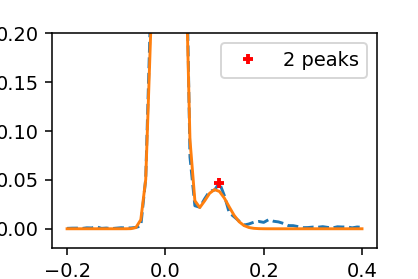

3  peaks found!!! [21 31 42]
0 21
1 31
2 42
6 [21 31 42] [ 0.01  0.11  0.22] [ 1.79906     0.04139153  0.01359087]
[ 0.06024201  0.00672055  0.01773523  0.00140704  0.10064359  0.02060935
  0.00103765  0.19962292  0.06986198]


<IPython.core.display.Javascript object>


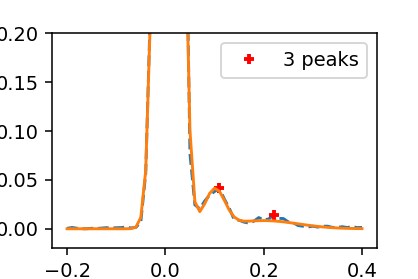

3  peaks found!!! [21 29 42]
0 21
1 29
2 42
7 [21 29 42] [ 0.01  0.09  0.22] [ 1.92387     0.03992257  0.01433389]
[ 0.06465713  0.00649368  0.01787535  0.00141542  0.09985028  0.02073649
  0.00109767  0.21362753  0.05945605]


<IPython.core.display.Javascript object>


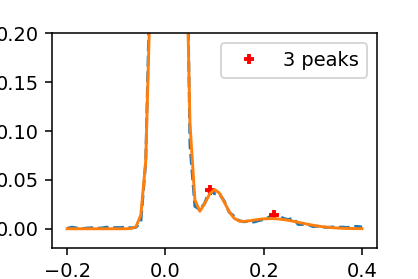

3  peaks found!!! [21 30 45]
0 21
1 30
2 45
8 [21 30 45] [ 0.01  0.1   0.25] [ 1.97673333  0.04332343  0.01774957]
[ 0.0677282   0.00592566  0.01808683  0.00168368  0.09945376  0.02150702
  0.00107896  0.23744826  0.04892035]


<IPython.core.display.Javascript object>


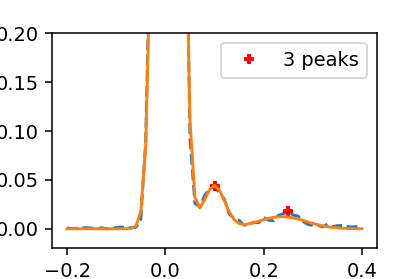

3  peaks found!!! [21 29 46]
0 21
1 29
2 46
9 [21 29 46] [ 0.01  0.09  0.26] [ 2.05676     0.04033023  0.01774917]
[ 0.07088874  0.00574177  0.01836868  0.00172609  0.10110698  0.02399115
  0.00110509  0.26248037  0.06066596]


<IPython.core.display.Javascript object>


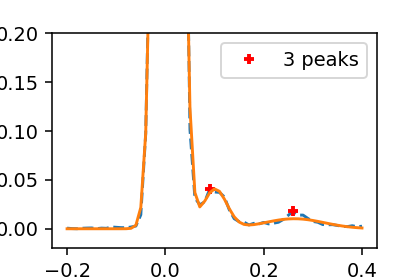

3  peaks found!!! [20 31 48]
0 20
1 31
2 48
10 [20 31 48] [ 0.    0.11  0.28] [ 2.09910667  0.04176047  0.01695863]
[ 0.07429922  0.00493577  0.01878683  0.00189221  0.09699345  0.02676749
  0.00130666  0.28032462  0.06671241]


<IPython.core.display.Javascript object>


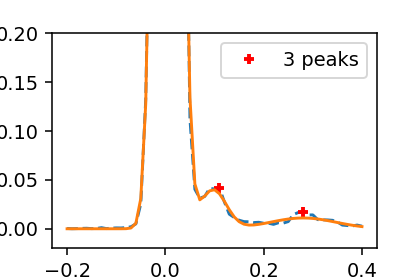

3  peaks found!!! [20 30 47]
0 20
1 30
2 47
11 [20 30 47] [ 0.    0.1   0.27] [ 2.15722667  0.0462336   0.01650227]
[ 0.0770904   0.00297277  0.019202    0.00216873  0.09609101  0.02776025
  0.00136578  0.29133081  0.06155713]


<IPython.core.display.Javascript object>


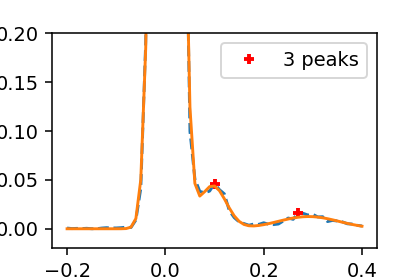

In [104]:
# find peaks and fit with Gaussion for the Q binned data
nQbins = np.int(len(qs)/3)
print nQbins
qbined, intbinned, _ = binningQ(qs,Zm,nQbins)
_ ,     errbinned, _ = binningQ(qs,Em,nQbins)# err may be zero, fails the fit
errbinned = np.where(errbinned==0.,errbinned.mean(),errbinned)

# binning the formfact
n = np.histogram(qs, bins=nQbins)[0]
n[np.argwhere(n==0)]=1 #repalce 0 by 1 for dividing later
mffbined = np.histogram(qs, bins=nQbins, weights=mff)[0]/ n
print mffbined

datFit = np.zeros([nQbins,11]) # storing qx,qy,qz,Emin,Emax,int,e,error,int,e,error

for i in xrange(nQbins):
    x, y, err = es, intbinned[:,i],errbinned[:,i]
    popt, perr, indexes = find_fit_pk(x, y, err, thres=0.006,min_dist=5)
    N = len(indexes)
    print i, indexes, x[indexes], y[indexes]  
    print popt
    if N==2:# only 2 or 3 peaks in the data. 
        datFit[i,0:8] = np.hstack((qbined[i],qbined[i],0,0.05,0.4,popt[3],popt[4],perr[4])).ravel()
    elif N==3:
        datFit[i,0:11] = np.hstack((qbined[i],qbined[i],0,0.05,0.4,popt[3],popt[4],perr[4],
                                                                           popt[6],popt[7],perr[7])).ravel()
#     elif N==4: # Four peaks can be found and when it is real then accept!!!!!
#         datFit[i,0:11] = np.hstack((qbined[i],qbined[i],2,0.05,0.4,popt[3],popt[4],perr[4],
#                                                                            popt[6],popt[7],perr[7])).ravel()
            
    plt.figure(figsize=(3,2))
    pplot(x, y, indexes)
    plt.plot(x,wrapper_fit_func(x,N,popt))
    plt.ylim([-0.02,0.2])
    plt.show()

12
[ 0.99860266  0.99648147  0.99338572  0.9893206   0.98429313  0.97831239
  0.97138968  0.96353875  0.95477601  0.94512071  0.93459515  0.92322479]
(12L,) (61L, 12L) [ 0.99860266  0.99648147  0.99338572  0.9893206   0.98429313  0.97831239
  0.97138968  0.96353875  0.95477601  0.94512071  0.93459515  0.92322479]


<IPython.core.display.Javascript object>


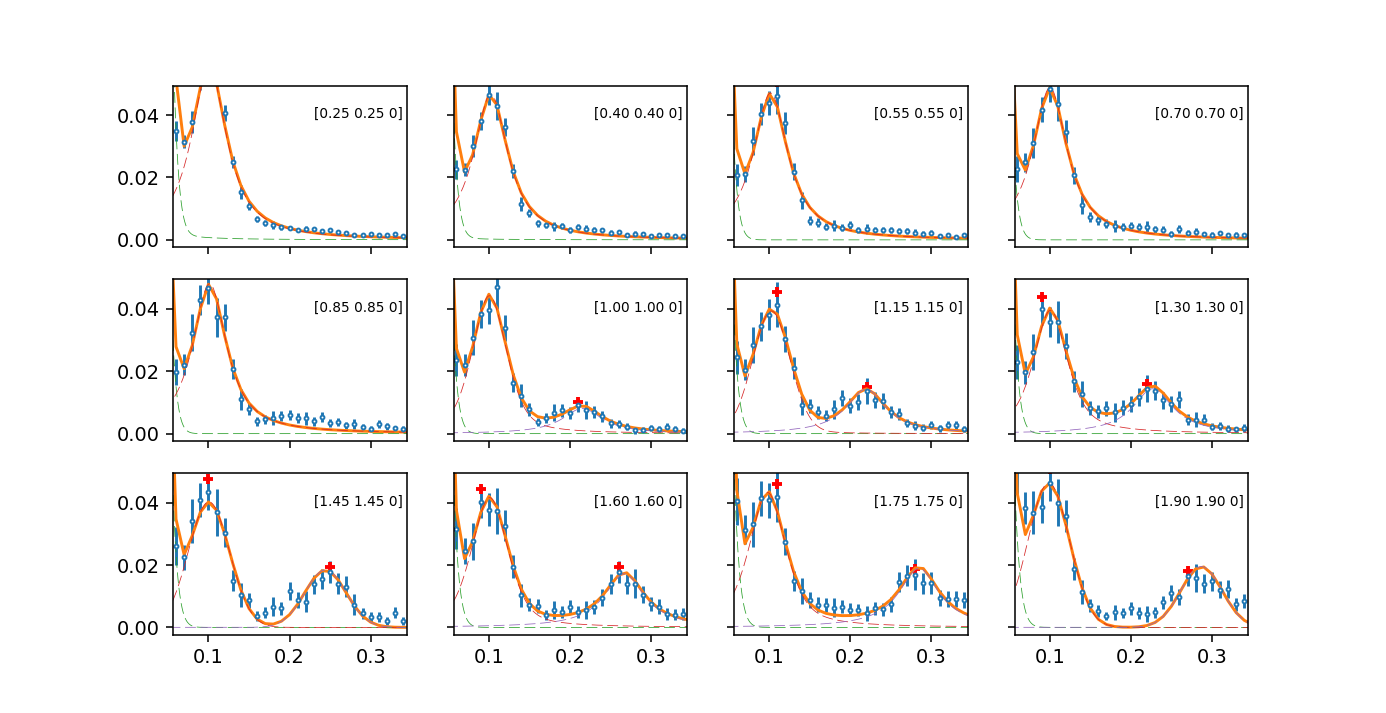

0
Q[HH2] amplitude e posistion e width e fraction e
0.25000
0.102549 0.000738 0.010258 0.000106 0.020039 0.000084 0.009363 0.003144
0.004556 0.000141 0.100722 0.000947 0.026244 0.001717 0.979747 0.077428

0.998602663798 0.00455622590597 0.00456260139407
1
Q[HH2] amplitude e posistion e width e fraction e
0.40000
0.075371 0.000713 0.009394 0.000139 0.020062 0.000110 0.004539 0.004304
0.003777 0.000150 0.102412 0.001182 0.025705 0.002329 1.000000 0.107673

0.996481469083 0.00377688621975 0.00379022223386
2
Q[HH2] amplitude e posistion e width e fraction e
0.55000
0.077433 0.000895 0.007248 0.000173 0.020225 0.000135 0.000000 0.004706
0.003820 0.000177 0.101609 0.001427 0.025917 0.002680 0.992629 0.126404

0.993385723525 0.003820442857 0.00384588057441
3
Q[HH2] amplitude e posistion e width e fraction e
0.70000
0.076672 0.000980 0.006302 0.000189 0.020223 0.000145 0.000000 0.004562
0.003967 0.000196 0.100368 0.001496 0.025867 0.002821 1.000000 0.134147

0.989320598432 0.00396675687425 0.0

In [229]:
# Ｆｉｎｄ　ｐｅａｋｓ　ａｎｄ　ｆｉｔ　ｗｉｔｈ　ＰＶ
'''There three peaks for (hh0): elastic, flat and dipersioning. 
Only two peaks should be found and fitted'''

# binning data
nQbins = np.int(len(qs)/3)
print nQbins
qbinned, intbinned, _ = binningQ(qs,Zm,nQbins)
_ , errbinned, _ = binningQ(qs,Em,nQbins)# err may be zero, fails the fit
errbinned = np.where(errbinned==0.,errbinned.mean()/10.,errbinned)

# binning the formfact
n = np.histogram(qs, bins=nQbins)[0]
n[np.argwhere(n==0)]=1 #repalce 0 by 1 for dividing later
mffbined = np.histogram(qs, bins=nQbins, weights=mff)[0]/ n
print mffbined

print qbinned.shape, intbinned.shape, mffbined

#datFit = np.zeros([nQbins,11]) # storing qx,qy,qz,Emin,Emax,int,e,err,int,e,err
datFit0 = np.zeros([nQbins,15])  # storing qx,qy,qz,Emin,Emax,Imin,Imax,int,err,e,err,int,err,e,err

fig, axarr = plt.subplots(3,4, figsize=(12,5),sharex=True,sharey=True)

for i in xrange(nQbins):
    print i
    x, y, err = es, intbinned[:,i], errbinned[:,i]
    indexes = peakutils.indexes(y, thres=0.005,min_dist=5)
    #print i, indexes, x[indexes], y[indexes]  
    
    N = len(indexes)
    if N!=0:    
        params_0, lowBound, highBound = [], [], []
        lb = [0,    -0.1,0.02,0]
        hb = [np.inf,0.4,0.03,1]
        for j in xrange(N):
            params_0 += [y[indexes[j]]*0.05, x[indexes[j]], 0.02, 0.1] # for PV
            #lowBound += lb
            #highBound += hb
            
        lowBound = [0,     -0.05, 0.02, 0,      0,   0.05,0.02,0 ]
        highBound = [np.inf,0.05, 0.03, 1,    np.inf,0.15,0.03,1]
        
        if N==3:
            lowBound +=  [0,     x[indexes[2]]-0.02, 0.02, 0]
            highBound += [np.inf,x[indexes[2]]+0.02, 0.03, 1]
            
        params_0 = np.asarray(params_0).ravel()
        bounds = [lowBound,highBound]

        popt, pcov = curve_fit(lambda x, *params: wrapper_fit_func_PV(x, N, params), x, y, p0=params_0,
                               bounds=bounds, sigma=err, absolute_sigma=True)# if initio value is outside bounds, error
        perr = np.sqrt(np.diag(pcov))

        pars_with_e = np.hstack( [qbinned[i], np.vstack([popt[0:],perr[0:]]).T.ravel()] ).ravel() # without the elastic
        #print pars_with_e
        print  "Q[HH2] amplitude e posistion e width e fraction e"
        row_format ="{:1.5f}\n"+"{:1.6f} {:1.6f} {:1.6f} {:1.6f} {:1.6f} {:1.6f} {:1.6f} {:1.6f}\n" * (len(pars_with_e)/8)
        print row_format.format(*pars_with_e)

        #fitpars.append(pars_with_e)
        
        # store for SpinW fitting
        if N==2:# only 2 or 3 peaks in the data
            #datFit[i,0:8] = np.hstack((qs[i],qs[i],0,0.05,0.4,popt[4],popt[5],perr[5])).ravel()
            minI, maxI = popt[4]*0.5, popt[4]*1.5
            print mffbined[i],popt[4], popt[4]/mffbined[i]
            datFit0[i,0:11] = np.hstack((qbinned[i],qbinned[i],0,0.05,0.35, minI/mffbined[i], maxI/mffbined[i],
                                        popt[4]/mffbined[i],perr[4]/mffbined[i], popt[5],perr[5])).ravel()# with I error
        elif N==3:
            #datFit[i,0:11] = np.hstack((qs[i],qs[i],0,0.05,0.4,popt[4],popt[5],perr[5],
                                       #popt[8],popt[9],perr[9])).ravel()
            minI, maxI = np.minimum(popt[4],popt[8]), np.maximum(popt[4],popt[8])
            print minI, maxI, mffbined[i], popt[4],popt[8], popt[4]/mffbined[i],popt[8]/mffbined[i]
            datFit0[i,0:15] = np.hstack((qbinned[i],qbinned[i],0,0.05,0.35, minI/mffbined[i], maxI/mffbined[i],# Change Q for differ data set
                                        popt[4]/mffbined[i],perr[4]/mffbined[i], popt[5],perr[5],
                                        popt[8]/mffbined[i],perr[8]/mffbined[i], popt[9],perr[9])).ravel()# with I error

        
#     plt.figure(figsize=(3,2))
#     #pplot(x, y, indexes)
#     plt.errorbar(x, y, err, fmt='o', ms=2,  mfc='white')
#     plt.plot(x[indexes], y[indexes]*1.1, 'r+', ms=5, mew=2,label='{} peaks'.format(len(indexes)))
    
#     plt.plot(x,wrapper_fit_func_PV(x,N,popt))
#     for i in np.arange(N):
#         #print popt[i*4:(i+1)*4]
#         plt.plot(eplot, pvoigt(eplot,*popt[i*4:(i+1)*4]),'--',lw=0.4)
#     plt.xlim([-0.15,0.4])
#     plt.ylim([-0.01,0.09])
#     plt.show()

    
    ax = axarr[i/4,np.remainder(i,4)]    
    ax.errorbar(x, y, err, fmt='o', ms=2,  mfc='white')
    ax.plot(x[indexes], y[indexes]*1.1, 'r+', ms=5, mew=2,label='{} peaks'.format(len(indexes)))
    
    ax.plot(x,wrapper_fit_func_PV(x,N,popt))
    for ii in np.arange(N):
        ax.plot(eplot, pvoigt(eplot,*popt[ii*4:(ii+1)*4]),'--',lw=0.4)
    ax.set_xlim([-0.15,0.4])
    ax.set_ylim([-0.01,0.09])
    ax.text(0.6,0.8, '[' +'{:1.2f} '.format(qbinned[i])*2+ '0]',fontsize=7, transform=ax.transAxes)
plt.suptitle(r'Nd$_2$Zr$_2$O$__7$ [hh0]')
#plt.savefig(r'D:\5_Neutron Scattering\8_IN5_ILL_2017_NdHfO\fitted_spinw_11l.pdf',bbox_inches="tight",verbose=True)
plt.show()

#print fitpars        

<IPython.core.display.Javascript object>


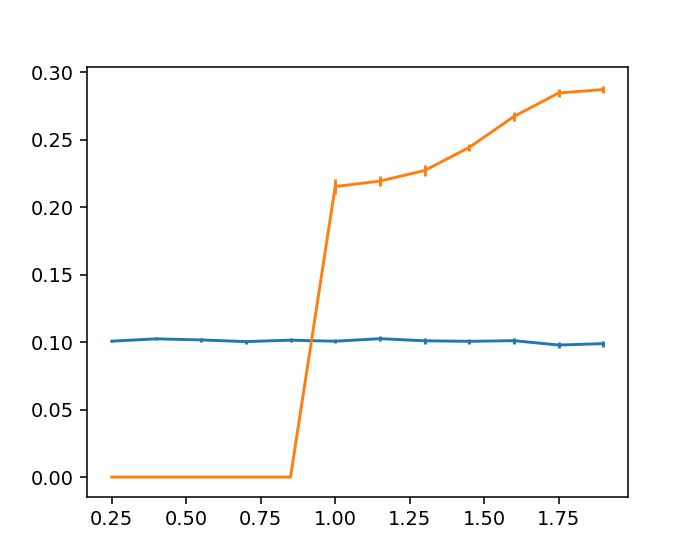

In [107]:
#print datFit
# Plot and save the fitted dispersion
# data with I error, minI and maxI
plt.figure(figsize=(5,4))
plt.errorbar(datFit0[:,0],datFit0[:,9],datFit0[:,10])
plt.errorbar(datFit0[:,0],datFit0[:,13],datFit0[:,14])
plt.show()

fname = 'fitted_spinw_hh0_qie.txt'
# data with I error, minI and maxI
# indexes  0    1     2      3        4       5        6       7      8       9       10    11     12       13     14 
header = ['QH','QK','QL','ENlim1','ENlim2','INlim1','INlim2','I1','sigmaI1','EN1','sigma1','I2','sigmaI2','EN2','sigma2']
Imax = datFit0[:,[7,11]].max()
#datFit[:,[5,6,7,8,11,12]] = datFit[:,[5,6,7,8,11,12]]/Imax # normalize the intensity
#np.savetxt(os.path.join(fpath,fname),datFit, fmt="%.5f", header=' '.join(header)) # workings


In [71]:
print datFit.shape, datFit0.shape

(10L, 15L) (12L, 15L)


<IPython.core.display.Javascript object>


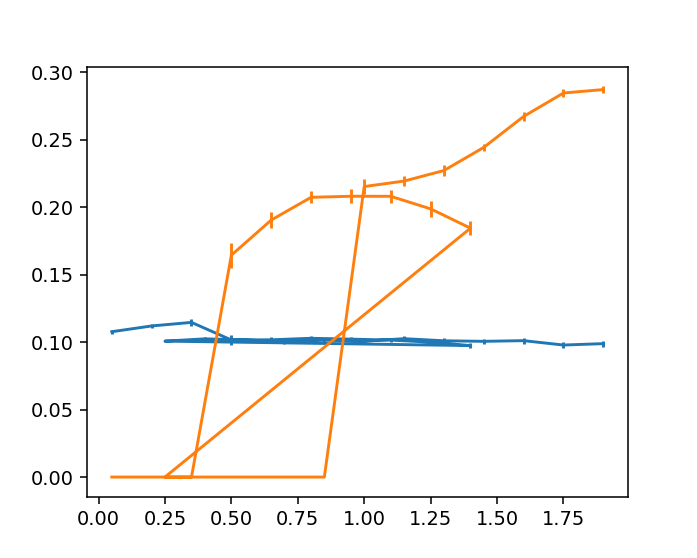

<IPython.core.display.Javascript object>


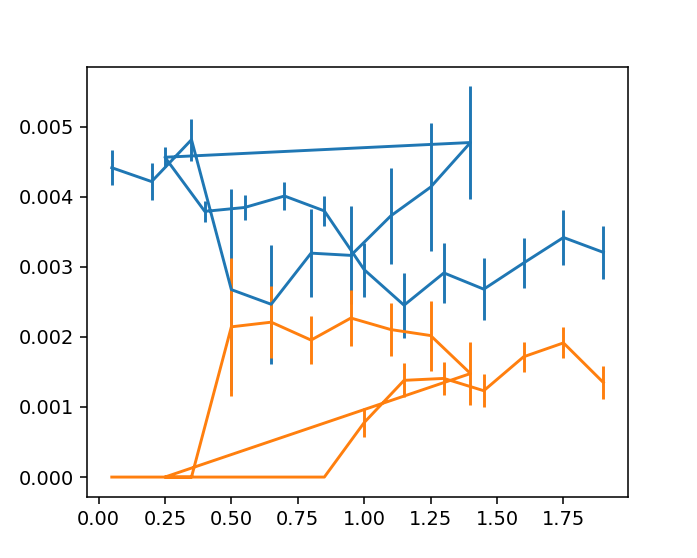

In [112]:
datFits = np.vstack([datFit,datFit0])
#print datFits
# data with I error, minI and maxI
plt.figure(figsize=(5,4))
plt.errorbar(datFits[:,0],datFits[:,9],datFits[:,10])
plt.errorbar(datFits[:,0],datFits[:,13],datFits[:,14])
plt.show()

plt.figure(figsize=(5,4))
plt.errorbar(datFits[:,0],datFits[:,7],datFits[:,8])
plt.errorbar(datFits[:,0],datFits[:,11],datFits[:,12])
plt.show()

fname = 'fitted_spinw_hh2_hh0_normed.txt'
# data with I error, minI and maxI
# indexes  0    1     2      3        4       5        6       7      8       9       10    11     12       13     14 
header = ['QH','QK','QL','ENlim1','ENlim2','INlim1','INlim2','I1','sigmaI1','EN1','sigma1','I2','sigmaI2','EN2','sigma2']

# Normalize to max or total intensity
# mask1, mask2 = datFits[:, 7] == 0., datFits[:, 11] == 0.
# datFits[mask1, 7] = np.nan
# datFits[mask2,11] = np.nan
# Imax, Imean = np.max(datFits[:,[7,11]]), np.nanmean(datFits[:,[7,11]])
# datFits[mask1, 7] = 0.
# datFits[mask2,11] = 0.
# datFits[:,[5,6,7,8,11,12]] = datFits[:,[5,6,7,8,11,12]]/Imean # normalize to total intensity
# datFits[:,[5,6,7,8,11,12]] = datFits[:,[5,6,7,8,11,12]]/Imax # normalize to max intensity
#print datFits[:, [7,11]],datFits[:, [7,11]].sum()
#datFits[:, [5,6,7,8,11,12]] = datFits[:, [5,6,7,8,11,12]]/datFits[:, [7,11]].sum() # normalize to total intensity
#print datFits[:, [7,11]]

np.savetxt(os.path.join(fpath,'fitted_spinw_hh2_hh0_ff_corr1.txt'),datFits, fmt="%.5f", header=' '.join(header)) # workings

In [184]:
print datFits[:,[7,11]]

mask1, mask2 = datFits[:, 7] == 0. , datFits[:, 11] == 0.
datFits[mask1, 7] = np.nan
datFits[mask2,11] = np.nan

# mask = np.where(datFits[:,[7,11]] == 0.)
# datFits[datFits[:, 7] == 0., 7] = np.nan
# datFits[datFits[:,11] == 0.,11] = np.nan

print datFits[:,[7,11]]
print np.nanmean(datFits[:,[7,11]]), np.nansum(datFits[:,[7,11]])/36
#datFits[:,[7,11]]#.mean()

[[ 0.00435993  0.        ]
 [ 0.00446095  0.        ]
 [ 0.00470546  0.        ]
 [ 0.00303127  0.00160323]
 [ 0.00280789  0.0018068 ]
 [ 0.00301789  0.00185631]
 [ 0.00334829  0.00188413]
 [ 0.00366084  0.00181908]
 [ 0.00434599  0.00157915]
 [ 0.00418473  0.00199408]
 [ 0.004616    0.        ]
 [ 0.00379889  0.        ]
 [ 0.00377982  0.        ]
 [ 0.00364244  0.        ]
 [ 0.00275941  0.        ]
 [ 0.00252959  0.00071759]
 [ 0.00252556  0.00125485]
 [ 0.00298658  0.00125641]
 [ 0.00253642  0.00114277]
 [ 0.00253717  0.00116566]
 [ 0.00261345  0.0012913 ]
 [ 0.0030147   0.00124359]]
[[ 0.00435993         nan]
 [ 0.00446095         nan]
 [ 0.00470546         nan]
 [ 0.00303127  0.00160323]
 [ 0.00280789  0.0018068 ]
 [ 0.00301789  0.00185631]
 [ 0.00334829  0.00188413]
 [ 0.00366084  0.00181908]
 [ 0.00434599  0.00157915]
 [ 0.00418473  0.00199408]
 [ 0.004616           nan]
 [ 0.00379889         nan]
 [ 0.00377982         nan]
 [ 0.00364244         nan]
 [ 0.00275941         nan]


# [11L] data

D:\5_Neutron Scattering\8_IN5_ILL_2017_NdHfO/e-q_11l.txt


<IPython.core.display.Javascript object>


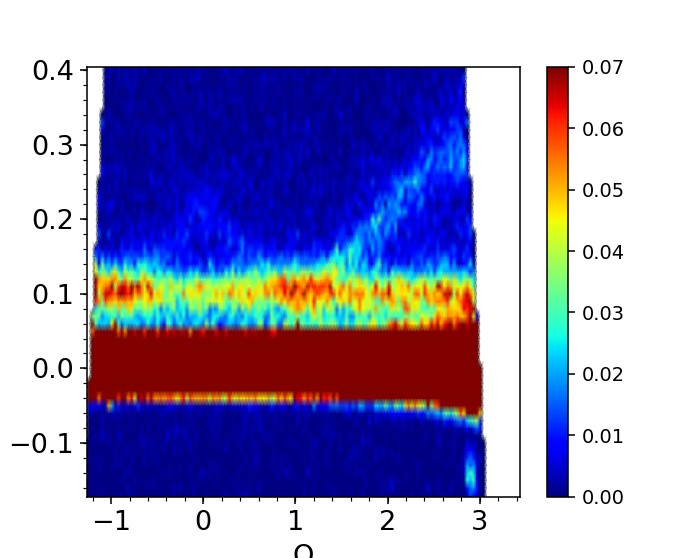

<IPython.core.display.Javascript object>


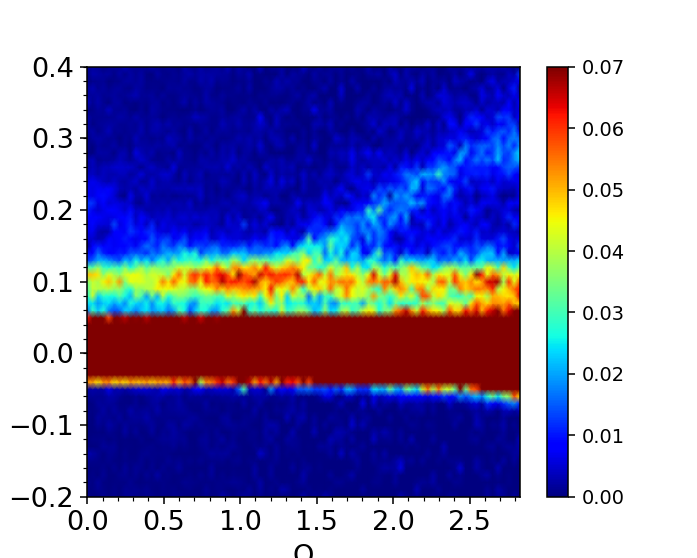

(81L,) (61L, 81L)
[ 1.          0.99997277  0.99989108  0.99975493  0.99956435  0.99931933
  0.99901992  0.99866613  0.998258    0.99779555  0.99727884  0.99670791
  0.99608281  0.99540359  0.99467033  0.99388309  0.99304193  0.99214695
  0.99119822  0.99019584  0.98913993  0.98803054  0.9868678   0.98565184
  0.98438276  0.98306071  0.98168581  0.98025822  0.97877807  0.97724571
  0.97566073  0.97402414  0.97233521  0.97059508  0.96880296  0.96696006
  0.96506557  0.96312077  0.96112479  0.959079    0.9569825   0.95483672
  0.95264071  0.950396    0.94810161  0.94575911  0.9433675   0.94092845
  0.93844088  0.93590656  0.93332438  0.93069616  0.92802079  0.92530014
  0.92253307  0.91972153  0.91686435  0.91396355  0.91101792  0.90802955
  0.90499722  0.90192309  0.89880588  0.89564784  0.89244767  0.88920768
  0.88592654  0.88260663  0.87924658  0.87584884  0.87241204  0.86893866
  0.86542732  0.86188056  0.85829696  0.85467914  0.85102565  0.84733916
  0.84361819  0.83986548  0.83607

In [245]:
# Load and plot 
X,Y,Z,E = loaddat(r'D:\5_Neutron Scattering\8_IN5_ILL_2017_NdHfO/e-q_11l.txt')
print fnames[0]
plotqemap(X,Y,Z,vmin=0,vmax=0.07)

# Crop the 2D data and plot
# use 'where' to select: if only give the condition, 'where' returns a tuple (array([index]),dtype=)!!!
xlim = np.where( (X[0,:]>=-1.09)&(X[0,:]<2.86) )[0]# Q limit
ylim = np.where( (Y[:,0]>=-0.2)&(Y[:,0]<=0.4) )[0] # energy limit

X = X[ylim,:][:,xlim]
Y = Y[ylim,:][:,xlim]
Z = Z[ylim,:][:,xlim]   
E = E[ylim,:][:,xlim] 

x0 = np.where(X[0,:]==0)[0]# index of 0: 30
Z[:,31:61:1] = (Z[:,31:61:1]+ Z[:,29::-1])/2 #fold the data
E[:,31:61:1] = (E[:,31:61:1]+ E[:,29::-1])/2

X = X[:,30:]
Y = Y[:,30:]
Z = Z[:,30:]
E = E[:,30:]

Zm = np.ma.masked_where(np.isnan(Z),Z) # mask Nan values then plot in white color
Em = np.ma.masked_where(np.isnan(Z),E)

plotqemap(X,Y,Zm,vmin=0,vmax=0.07)

# the q and e 1D array [hh0]
qs = X[0,:]
es = Y[:,0]
print qs.shape, Zm.shape
# Form factor of 11l
hkl = np.vstack([qs,qs,np.repeat(0.,qs.shape)]).T
qmod = LA.norm( np.multiply(hkl,rA), axis=1)
mff = ndformfact(qmod)
print mff

27
[ 0.03535497  0.14142     0.247485    0.35355     0.459615    0.56568
  0.67174467  0.777809    0.883874    0.98993767  1.09600333  1.20206667
  1.30813333  1.41419667  1.52026333  1.62632667  1.73239333  1.83845667
  1.94452333  2.05058667  2.15665333  2.26271667  2.36878333  2.47484667
  2.58091333  2.68697667  2.79304333]


<IPython.core.display.Javascript object>


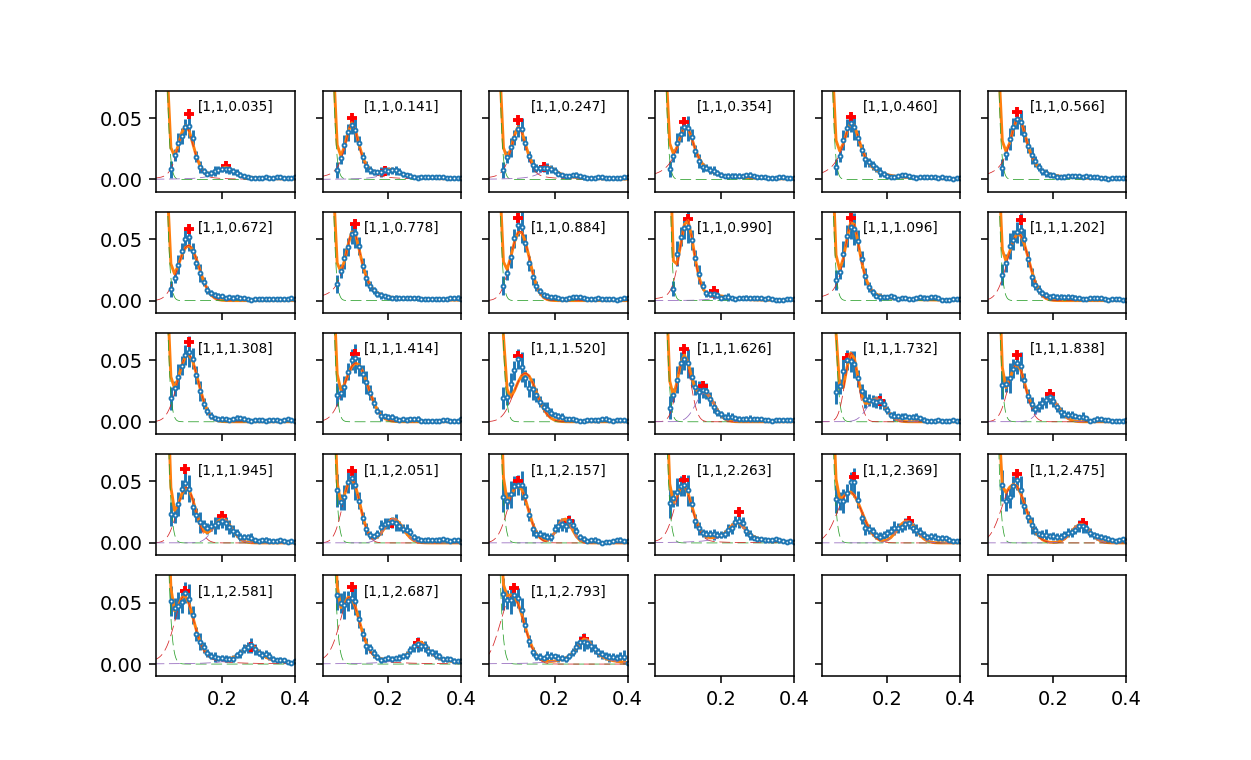

0 [21 31 41] [ 0.01  0.11  0.21] [ 1.77209833  0.04815338  0.0102971 ]
Q[11L] amplitude e posistion e width e fraction e
0.03535
0.080360 0.001672 0.006851 0.000308 0.020386 0.000225 0.000000 0.006921
0.002678 0.000556 0.100630 0.002325 0.025403 0.003220 0.399842 0.532104
0.000874 0.000285 0.210680 0.007678 0.030000 0.014189 1.000000 0.517182

0.000873590035117 0.00267756956571 0.999954615238 0.00267756956571 0.000873590035117 0.00267769109208 0.000873629684592
1 [21 30 39] [ 0.01  0.1   0.19] [ 1.692145    0.04546553  0.00631329]
Q[11L] amplitude e posistion e width e fraction e
0.14142
0.080361 0.001665 0.006675 0.000314 0.020581 0.000239 0.004023 0.008156
0.003059 0.000540 0.100724 0.002356 0.023347 0.004047 0.809651 0.413467
0.000648 0.000283 0.210000 0.009723 0.030000 0.016826 1.000000 0.705579

0.000647815800973 0.00305913388013 0.999546203918 0.00305913388013 0.000647815800973 0.00306052273336 0.000648109910711
2 [21 30 37] [ 0.01  0.1   0.17] [ 1.72954     0.04391853  0.0094367

In [250]:
# Ｆｉｎｄ　ｐｅａｋｓ　ａｎｄ　ｆｉｔ　ｗｉｔｈ　ＰＶ
'''There three peaks for (11l): elastic, flat and dipersioning. 
Only two peaks should be found and fitted'''
from scipy.signal import savgol_filter

# binning data
nQbins = np.int(len(qs)/3)
print nQbins
qbinned, intbinned, _ = binningQ(qs,Zm,nQbins)
_ , errbinned, _ = binningQ(qs,Em,nQbins)# err may be zero, fails the fit
errbinned = np.where(errbinned==0., errbinned.mean()/10., errbinned)
print qbinned
# binning the formfact
n = np.histogram(qs, bins=nQbins)[0]
n[np.argwhere(n==0)]=1 #repalce 0 by 1 for dividing later
mffbined = np.histogram(qs, bins=nQbins, weights=mff)[0]/ n

#print qbinned, intbinned.shape, mffbined

#datFit = np.zeros([nQbins,11]) # storing qx,qy,qz,Emin,Emax,int,e,err,int,e,err
datFit1 = np.zeros([nQbins,15])  # storing qx,qy,qz,Emin,Emax,Imin,Imax,int,err,e,err,int,err,e,err

fig, axarr = plt.subplots(5, 6, figsize=(12,5),sharex=True,sharey=True)

for i in xrange(nQbins):
    x, y, err = es, intbinned[:,i], errbinned[:,i]
    yhat = savgol_filter(y,5,3)
    indexes = peakutils.indexes(yhat, thres=0.0055, min_dist=4)
    print i, indexes, x[indexes], y[indexes]  
    
    N = len(indexes)
    if N!=0:    
        params_0, lowBound, highBound = [], [], []
        lb = [0,    -0.10,0.02,0]
        hb = [np.inf,0.35,0.03,1]
        for j in xrange(N):
            params_0 += [y[indexes[j]]*0.05, x[indexes[j]], 0.03, 0.1] # for PV
#             lowBound += lb
#             highBound += hb

        lowBound = [0,     -0.05, 0.02, 0,      0,   0.059,0.02,0 ]
        highBound = [np.inf,0.05, 0.03, 1,    np.inf,0.15,0.04,1]
        
        if N==3:
            lowBound +=  [0,     x[indexes[2]]-0.02, 0.02, 0]
            highBound += [np.inf,x[indexes[2]]+0.02, 0.03, 1]
            
        params_0 = np.asarray(params_0).ravel()
        bounds = [lowBound,highBound]

        popt, pcov = curve_fit(lambda x, *params: wrapper_fit_func_PV(x, N, params), x, y, p0=params_0,
                               bounds=bounds, sigma=err, absolute_sigma=True)# if initio value is outside bounds, error
        perr = np.sqrt(np.diag(pcov))

        pars_with_e = np.hstack( [qbinned[i], np.vstack([popt[0:],perr[0:]]).T.ravel()] ).ravel() # without the elastic
        #print pars_with_e
        print  "Q[11L] amplitude e posistion e width e fraction e"
        row_format ="{:1.5f}\n"+"{:1.6f} {:1.6f} {:1.6f} {:1.6f} {:1.6f} {:1.6f} {:1.6f} {:1.6f}\n" * (len(pars_with_e)/8)
        print row_format.format(*pars_with_e)

        #fitpars.append(pars_with_e)
        
        # store for SpinW fitting
        if N==2:# only 2 or 3 peaks in the data
            minI, maxI = popt[4]*0.5, popt[4]*1.5
            print mffbined[i],popt[4], popt[4]/mffbined[i]
            datFit1[i,0:11] = np.hstack((1.,1.,qbinned[i], 0.05,0.35, minI/mffbined[i], maxI/mffbined[i],
                                        popt[4]/mffbined[i],perr[4]/mffbined[i], popt[5],perr[5])).ravel()# with I error
        elif N==3:
            minI, maxI = np.minimum(popt[4],popt[8]), np.maximum(popt[4],popt[8])
            print minI, maxI, mffbined[i], popt[4],popt[8], popt[4]/mffbined[i],popt[8]/mffbined[i]
            datFit1[i,0:15] = np.hstack((1.,1.,qbinned[i], 0.05,0.35, minI/mffbined[i], maxI/mffbined[i],# Change Q for differ data set
                                        popt[4]/mffbined[i],perr[4]/mffbined[i], popt[5],perr[5],
                                        popt[8]/mffbined[i],perr[8]/mffbined[i], popt[9],perr[9])).ravel()# with I error

# Plot separate figs        
#     plt.figure(figsize=(3,2))
#     #pplot(x, y, indexes)
#     plt.errorbar(x, yhat, err, fmt='o', ms=2,  mfc='white')
#     plt.plot(x[indexes], y[indexes]*1.1, 'r+', ms=5, mew=2,label='{} peaks'.format(len(indexes)))
    
#     plt.plot(x,wrapper_fit_func_PV(x,N,popt))
#     for i in np.arange(N):
#         #print popt[i*4:(i+1)*4]
#         plt.plot(eplot, pvoigt(eplot,*popt[i*4:(i+1)*4]),'--',lw=0.4)
#     plt.xlim([-0.15,0.4])
#     plt.ylim([-0.01,0.09])
#     plt.show()
    
    ax = axarr[i/6,np.remainder(i,6)]    
    ax.errorbar(x, yhat, err, fmt='o', ms=2,  mfc='white')
    ax.plot(x[indexes], y[indexes]*1.1, 'r+', ms=5, mew=2,label='{} peaks'.format(len(indexes)))
    
    ax.plot(x,wrapper_fit_func_PV(x,N,popt))
    for k in np.arange(N):
        #print popt[i*4:(i+1)*4]
        ax.plot(eplot, pvoigt(eplot,*popt[k*4:(k+1)*4]),'--',lw=0.4)
    ax.set_xlim([-0.15,0.4])
    ax.set_ylim([-0.01,0.09])
    ax.text(0.3,0.8,'[1,1,'+'{:1.3f}]'.format(qbinned[i]),fontsize=7, transform=ax.transAxes)
plt.suptitle(r'Nd$_2$Zr$_2$O$__7$ [11L]')
#plt.savefig(r'D:\5_Neutron Scattering\8_IN5_ILL_2017_NdHfO\fitted_spinw_11l.pdf',bbox_inches="tight",verbose=True)
plt.show()
#print fitpars        

<IPython.core.display.Javascript object>


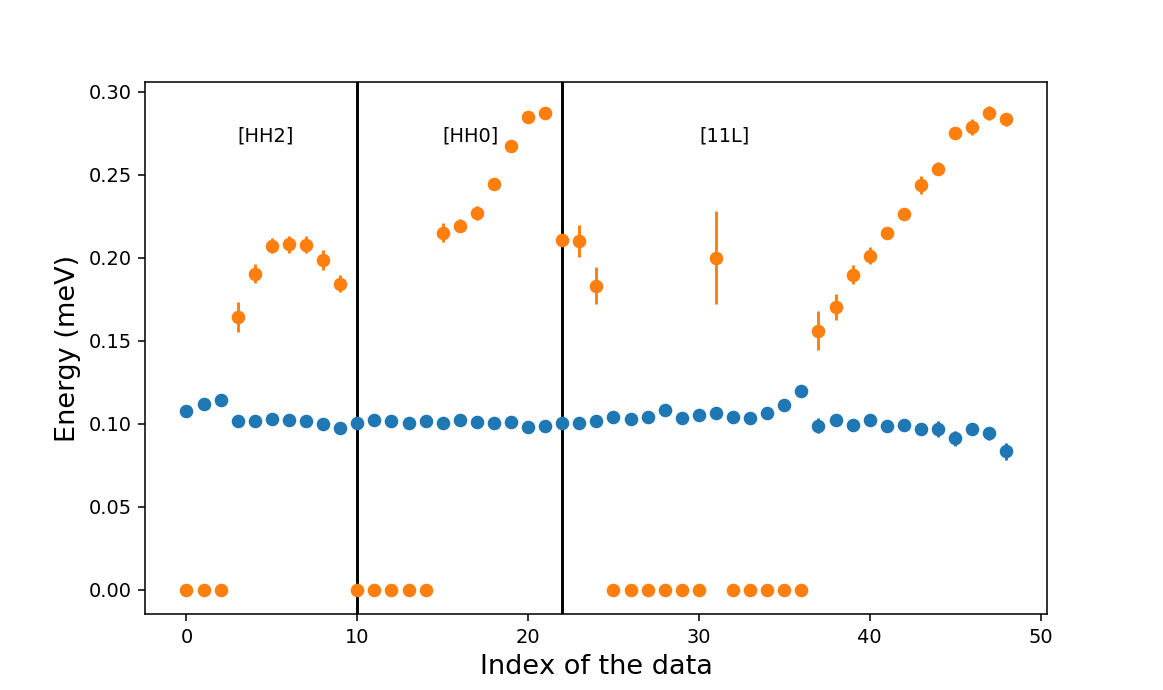

<IPython.core.display.Javascript object>


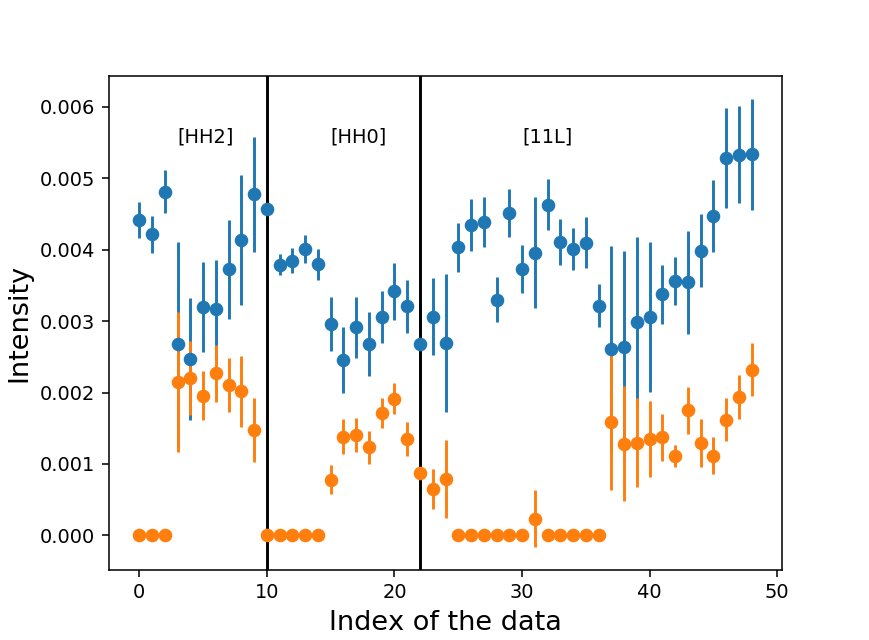

In [244]:
datFits = np.vstack([datFit,datFit0,datFit1])
#print datFits
# data with I error, minI and maxI
plt.figure(figsize=(5,4))
xaxis = np.arange(len(datFits[:,0]))
plt.errorbar(xaxis,datFits[:,9],datFits[:,10],fmt='o')
plt.errorbar(xaxis,datFits[:,13],datFits[:,14],fmt='o')
plt.xlabel('Index of the data',size=14)
plt.ylabel(r'Energy (meV)',fontsize=14)
plt.axvline(x=10,c='black')
plt.axvline(x=22,c='black')
plt.text(3,0.27,'[HH2]');plt.text(15,0.27,'[HH0]');plt.text(30,0.27,'[11L]')
plt.show()

plt.figure(figsize=(5,4))
plt.errorbar(xaxis,datFits[:,7],datFits[:,8],fmt='o')
plt.errorbar(xaxis,datFits[:,11],datFits[:,12],fmt='o')
plt.xlabel('Index of the data',size=14)
plt.ylabel(r'Intensity',fontsize=14)
plt.axvline(x=10,c='black')
plt.axvline(x=22,c='black')
texth = 0.0055
plt.text(3,texth,'[HH2]');plt.text(15,texth,'[HH0]');plt.text(30,texth,'[11L]')
plt.show()

fname = 'fitted_spinw_hh2_hh0_normed.txt'
# data with I error, minI and maxI
# indexes  0    1     2      3        4       5        6       7      8       9       10    11     12       13     14 
header = ['QH','QK','QL','ENlim1','ENlim2','INlim1','INlim2','I1','sigmaI1','EN1','sigma1','I2','sigmaI2','EN2','sigma2']

# Normalize to max or total intensity
# mask1, mask2 = datFits[:, 7] == 0., datFits[:, 11] == 0.
# datFits[mask1, 7] = np.nan
# datFits[mask2,11] = np.nan
# Imax, Imean = np.max(datFits[:,[7,11]]), np.nanmean(datFits[:,[7,11]])
# datFits[mask1, 7] = 0.
# datFits[mask2,11] = 0.
# datFits[:,[5,6,7,8,11,12]] = datFits[:,[5,6,7,8,11,12]]/Imean # normalize to total intensity
# datFits[:,[5,6,7,8,11,12]] = datFits[:,[5,6,7,8,11,12]]/Imax # normalize to max intensity
#print datFits[:, [7,11]],datFits[:, [7,11]].sum()
#datFits[:, [5,6,7,8,11,12]] = datFits[:, [5,6,7,8,11,12]]/datFits[:, [7,11]].sum() # normalize to total intensity
#print datFits[:, [7,11]]

#np.savetxt(os.path.join(fpath,'fitted_spinw_hh2_hh0_11l_ff_corr2.txt'),datFits, fmt="%.5f", header=' '.join(header)) # workings

# HH2-H data

<IPython.core.display.Javascript object>


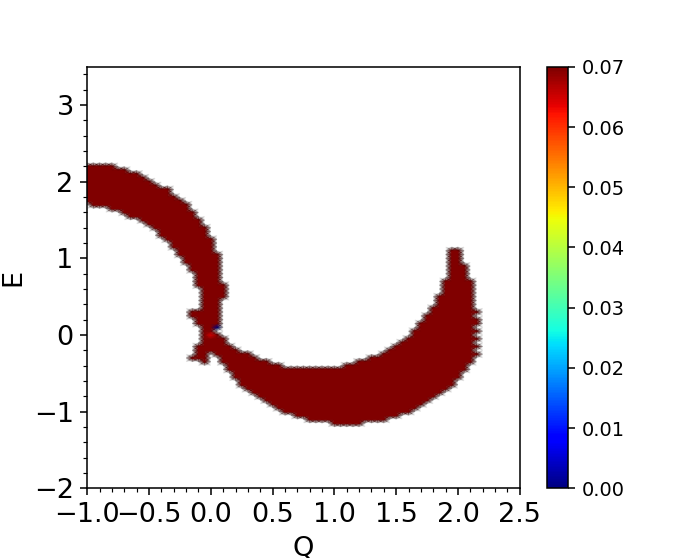

(<matplotlib.figure.Figure at 0x9dc937f0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x9e48a748>)

In [163]:
# Load and plot 
X,Y,Z,E = loaddat(fnames[1])
plotqemap(X,Y,Z,vmin=0,vmax=0.07)

# Crop the 2D data and plot
# use 'where' to select: if only give the condition, 'where' returns a tuple (array([index]),dtype=)!!!
# xlim = np.where( (X[0,:]>=0.2)&(X[0,:]<2) )[0]# Q limit
# ylim = np.where( (Y[:,0]>=-0.2)&(Y[:,0]<=0.4) )[0] # energy limit
# # or without 'where': output is an bool array
# # xlim = (X[0,:]>=0.2)&(X[0,:]<2) # Q limit
# # ylim = (Y[:,0]>=-0.2)&(Y[:,0]<=0.4)  # energy limit

# # the q and e 1D array
# qs = X[0,xlim]
# es = Y[ylim,0]

# # the cropped X; X = X[np.ix_(ylim,xlim)] also works using this corss indexing but not X = X[ylim,xlim]
# X = X[ylim,:][:,xlim]
# Y = Y[ylim,:][:,xlim]
# Z = Z[ylim,:][:,xlim]   
# E = E[ylim,:][:,xlim] 
# Zm = np.ma.masked_where(np.isnan(Z),Z) # mask Nan values then plot in white color
# Em = np.ma.masked_where(np.isnan(Z),E)
# plotqemap(X,Y,Zm,vmin=0,vmax=0.07)
# print Zm.shape


<IPython.core.display.Javascript object>


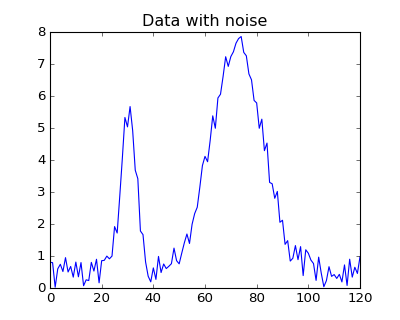

[31 74]
(array([ 31.,  74.]), array([ 5.67012229,  7.85866727]))
[[  5.5559428   30.51686219   3.08435149]
 [  7.72784855  72.96941327   8.20458818]]


<IPython.core.display.Javascript object>


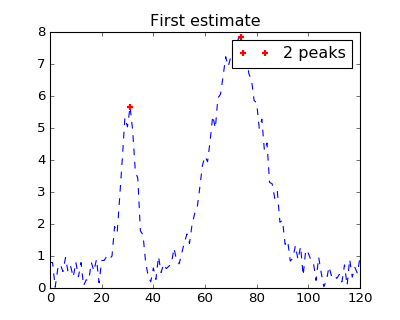

In [8]:
# test tuple
a = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
index = -1

newa = np.delete(a, index)
print newa

a = (1, 2, 3)
b = a + (4, 5, 6)
print b

In [399]:
# Ｓｕｂｔｒａｃｔｉｏｎ:　６００ｍＫ－５０ｍＫ　ａｔ　０．０１ｍｅＶ
fpath=r'D:\5_Neutron Scattering\8_IN5_ILL_2017_NdHfO/'
fname = '*.mat'

ii=0 #index for different files
fnames = []; idx = 0 
for file in os.listdir(fpath):
    if fnmatch.fnmatch(file, fname):       
        print idx, file
        fnames.append(os.path.join(fpath,file))
        idx = idx + 1
print fnames[0]

mat1 = scipy.io.loadmat(fnames[2])
mat2 = scipy.io.loadmat(fnames[4])
#print mat1['x'], mat1['y'],mat1['dat']

# use h5py to load the matlab data: not working
#f = h5py.File(fpath+'nho_6A_0p6K_iso_energy_E=0p01meV.mat','r')
# data = f.get('data/variable1') 
# data = np.array(data) # For converting to numpy array


0 e-q_hh2.mat
1 iso_energy_E=0p01meV.mat
2 iso_energy_E=0p03meV.mat
3 nho_6A_0p6K_iso_energy_E=0p01meV.mat
4 nho_6A_0p6K_iso_energy_E=0p03meV.mat
D:\5_Neutron Scattering\8_IN5_ILL_2017_NdHfO/e-q_hh2.mat


In [400]:
# loda dat
X, Y = np.meshgrid(mat1['x'], mat1['y'])
print X.shape

dat = mat2['dat'] - mat1['dat']
zeros_at = dat==0
Zm = np.ma.masked_where(dat==0,dat)# mask Nan values then plot in white color

(105L, 113L)


[[-0.05  0.1 ]
 [-0.05  0.1 ]]


<IPython.core.display.Javascript object>


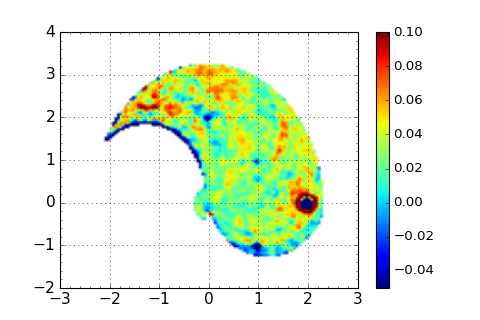

C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\smoothn.py:258: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Lambda = Lambda + (cos(pi*(arange(1,sizy[i]+1) - 1.)/sizy[i]).reshape(siz0))


In [401]:
# Plot
vlims = np.array([[-0.05,0.1],[-0.05,0.1]])
print vlims
idx = 1 
fig = plt.figure(figsize=(6,4))
Z,s,exitflag,Wtot = smoothn(dat,s=0.5) # smooth
Zm = np.ma.masked_where(zeros_at,Z) # mask Nan values then plot in white color

pcol = plt.pcolormesh(X,Y, Zm.T, vmin=vlims[idx,0], vmax=vlims[idx,1], cmap='jet',linewidth=0,rasterized=True,shading='gouraud')# '_r' is reversed colormap
pcol.set_edgecolor('face') # remove the white lines in the plot
plt.grid()
plt.minorticks_on()
plt.xticks( color='k', size=14)
plt.yticks( color='k', size=14)

# set colorbar and its properties
cb = plt.colorbar(aspect=20,pad=0.05,orientation="vertical") # label='Intensity', ticks=range(0,100)

plt.show()

In [5]:
print list(Xm)

#print np.shape(np.ma.compressed(Zm1))

[array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan]), array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan

# Learn find peaks

[30 73]
(array([ 30.,  73.]), array([ 5.49735563,  7.77907788]))
[[  5.31980845  30.45230355   3.24580836]
 [  7.40125009  72.49495685  12.54751603]]


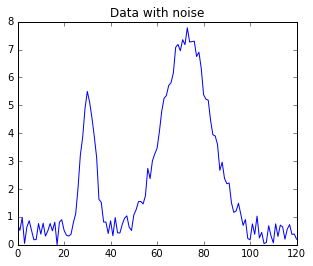

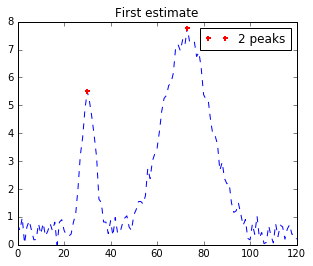

In [7]:
import peakutils
from peakutils.plot import plot as pplot
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
centers = (30.5, 72.3)
x = np.linspace(0, 120, 121)
y = (peakutils.gaussian(x, 5, centers[0], 3) +
    peakutils.gaussian(x, 7, centers[1], 10) +
    np.random.rand(x.size))
plt.figure(figsize=(5,4))
plt.plot(x, y)
plt.title("Data with noise")

indexes = peakutils.indexes(y, thres=0.5, min_dist=30)
print(indexes)
print(x[indexes], y[indexes])
peaks_x = peakutils.interpolate_xu(x,y,ind=indexes, width=5)
print(peaks_x)

plt.figure(figsize=(5,4))
pplot(x, y, indexes)
plt.title('First estimate')